In [1222]:
%load_ext autoreload
%autoreload 2

from doc2vec.util.Logger import Logger
from doc2vec.preprocessor.preprocessing import *
from soyspacing.countbase import CountSpace
from soynlp.normalizer import *
from doc2vec.util.common import set_pandas_format, set_matplotlib_sns_font, save_pickle, load_pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
import multiprocessing
from doc2vec.preprocessor.multiprocess import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1049]:
set_pandas_format() 
set_matplotlib_sns_font()
logger = Logger(file_name=__name__).logger

# 단어 Cleaning 

## HTML 태그 등 제거

참고: https://regexr.com/

- URL PATTERN
```
URL_PATTERN = re.compile(
	r'^(?:http|ftp)s?://'  # http:// or https://
	r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'  # domain...
	r'localhost|'  # localhost...
	r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'  # ...or ip
	r'(?::\d+)?'  # optional port
	r'(?:/?|[/?]\S+)$', re.IGNORECASE)
```


- html 패턴
```
HTML_PATTERN = re.compile('<.*?>')
```

- &quot;와 같은 태그
```
HTML_CHAR_PATTERN = re.compile("&.*?;")
```

- 다중 스페이스(빈칸)
```
MULTIPLE_SPACES = re.compile(' +', re.UNICODE)
```

- WIKI 태그
```
WIKI_REMOVE_CHARS = re.compile("'+|(=+.{2,30}=+)|__TOC__|(ファイル:).+|:(en|de|it|fr|es|kr|zh|no|fi):|\n", re.UNICODE)
WIKI_SPACE_CHARS = re.compile("(\\s|゙|゚|　)+", re.UNICODE)
WIKI_REMOVE_TOKEN_CHARS = re.compile("(\\*$|:$|^파일:.+|^;)", re.UNICODE)
```

- EMAIL PATTERN
```
EMAIL_PATTERN = re.compile("(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", re.UNICODE)
```

- [출처=이데일리] 또는 [출처=http...] 또는 〈사진-연합뉴스〉 제거 와 같은 패턴
```
REF_PATTERN = re.compile("\[출처(.*?)\]", re.UNICODE)
REF_PATTERN2 = re.compile("〈사진(.*?)〉", re.UNICODE)
```

- 일부 구두점 제거
```
# PUNCTATION_PATTER = re.compile('[-=+,#/\?:^$.@*\"※~&%ㆍ·!』\\‘|\(\)\[\]\<\>`\'…》;]', re.UNICODE)
PUNCTATION_PATTER = re.compile('[-=+,#/\?:^$@*\"※&%ㆍ·!』\\‘|\(\)\[\]\<\>`\'…》;]', re.UNICODE)
```

In [3]:
text1 ="""<!-- @ckeditor_contents_s@ --><div id='div_NV10442989' class='jtbc_vod'></div>초선 의원과 각 대선주자 캠프를 중심으로 커지고 있는 민주당의 &#39;경선 연기론&#39;. 민주당 초선 모임 &#39;더민초&#39;, 오늘(15일) 아침에 회의를 열었는데요. 대선 경선 연기가 주요 화두였습니다.<!-- @ckeditor_contents_e@ -->"""

text2 = """
<img src="http://photo.jtbc.joins.com/news/2011/12/02/20111202001000545.jpg" alt="" width="130" />
안진 대표이사 1997년 외환위기 당시 33개나 됐던 우리나라 은행은 이제 10여 개의 금융지주그룹과 개별은행으로 단출해졌다. 그동안 20여 개 은행이 퇴출 또는 합병으로 사라졌고 그중 제일과 외환·한미은행은 외국회사에 매각됐다. 제일은행은 미국계 사모펀드인 뉴브리지캐피털에 팔렸다가 스탠더드차터드가 인수해 운영 중이다. 한미은행도 미국계 사모펀드인 칼라일에 넘어갔다가 한국씨티은행이 인수 통합했다.

　요즘 논란의 대상이 되고 있는 외환은행은 외환위기 이후 독일계 은행인 코메르츠에 팔렸다. 2003년 카드대란으로 금융시장이 불안정해지자 대주주와 2대 주주인 수출입은행은 증자를 통한 경영 정상화를 시도했다. 그러나 당시 코메르츠은행은 증자여력이 없었고, 공적자금 투입에 대한 여론도 부정적이었다.

　차선책으로 떠오른 것이 제3자 매각이었고, 인수주체로 물망에 오른 대상은 미국계 사모펀드인 론스타였다. 당시에도 헐값 매각과 대주주 적격성 시비가 있었지만 선택의 여지가 크지 않았던 정부 당국은 금융시장 안정을 위해 신속하게 의사결정을 내렸다.

　알려진 대로 현재 론스타는 외환은행 매각과 관련해 '먹튀' 논란에 휩싸여 있다. 재미있는 것은, 과거 국내기업들이 외국기업에 넘어갈 때는 별 얘기가 없다가 유독 이번에만 말들이 많다는 점이다. 뉴브리지캐피털이 제일은행을 팔 때나, 칼라일이 한미은행을 매각할 때는 먹튀 시비가 없었다. 

　물론 과거와 지금은 상황이 다르다고 할 수 있다. 우리가 아쉬운 게 많아 앞뒤 돌볼 틈 없이 매각을 서둘렀던 때에 비해 지금은 여력이 생겼으니 이것저것 챙겨봐야 한다는 주장이다. 무엇보다 외환은행을 인수할 당사자가 우리 기업(하나금융)이어서 더 억울한 심정이 들 수도 있을 법하다.

　그러나 이 대목에서 분명히 알아둬야 할 것은 이른바 외국계 사모펀드의 속성과 사업방식이다. 론스타나 뉴브리지캐피털 등 사모펀드들은 기본적으로 위험을 감수하고 고수익을 창출하기 위해 투자자로부터 자금을 끌어 모은 펀드다. 실제로 이러한 사모펀드들은 통상 연간 30% 정도의 수익률을 목표로 한다. 이들은 대개 곤경에 처한 기업을 인수해 정상화시키고 나서 3~5년 뒤 회사를 처분하고 빠져 나온다. 그래야 투자자들에게 약속한 만큼의 이익을 실현시켜 줄 수 있고 다음에 다시 투자자를 모을 수 있다.

　론스타가 외환은행 매각으로 거둬들일 이익이 5조원에 달한다고 한다. 짧은 시간에 큰돈을 벌어 간다니 배가 아프긴 하다. 하지만 2조원 이상을 '무려' 8년간 투자했고, 배당 등을 감안할 때 연간 수익률이 약 18%에 그친다고 하니 그들 입장에서는 과하지 않다고 할 수도 있다. 외환위기 때 국내 부실채권과 부동산을 사들인 골드먼삭스 등 외국 투자은행은 연간 30% 이상의 수익률을 올렸다. 2003년 가을 종합주가지수가 780 선에 머물고 있을 때 우량상장 기업에 투자했더라도 그 정도의 수익률은 거뜬하게 올렸을 것이다.

　론스타를 두둔하고 싶은 생각은 없다. 외환은행 인수를 위해 금융위원회에 인가신청 할 당시의 주주 구성을 나중에 실제 투자할 때는 다른 회사로 바꿔 대주주 적격성 시비를 피해가려 한 것은 꼼수를 부린 느낌마저 든다. 그러나 8년이 지난 일을 지금 들춰본들 무슨 실익이 있겠는가. 같은 논리대로라면 제일은행과 한미은행을 인수한 뉴브리지캐피털과 칼라일도 대주주 적격성 심사를 해야 하나.

　걸림돌은 더 있다. 수익률을 지상과제로 삼는 속성상 사모펀드들은 돈이 된다 싶으면 대상이 일반기업이건 금융회사건 가리지 않고 투자한다. 따라서 산업자본인지 금융자본인지 구분하는 것 자체가 애매하다.  징벌적 매각명령을 통해 현재의 시장가격에 매도하도록 해야 한다는 주장도 다분히 감정적이다. 실제로 유럽 재정위기 등으로 현재 주가가 과도하게 떨어진 상태이고, 하나금융의 예정 인수가격은 외환은행 장부가 수준에 불과하다. 

　하루 빨리 비생산적인 먹튀 논쟁에서 헤어나와 전열을 가다듬고 미래로 나아갈 준비를 해야 한다. 우리도 골드먼삭스와 같은 대형 투자은행을 키워야 한다. 론스타에 버금가는 사모펀드를 조성해 유럽시장에 싸게 나온 알짜 기업을 사러 가야 한다. 또 향후 중국 경제가 휘청거릴 때를 대비해 부실채권이나 부실기업을 싸게 사 돈을 벌 기회를 준비해야 한다.

　그런데도 대형 종합 투자사업자 육성법안인 자본시장법 개정안이 론스타의 먹튀 논란에 파묻혀 국회에서 논의조차 되지 못하고 있으니 안타깝다. 우리 금융산업에서 관치나 '국민정서법'이 아니라 법치가 정착되려면 좀 더 차가운 머리가 필요해 보인다.

이재술 딜로이트 안진 대표이사
		"""

text3="""<object style='height: 390px; width: 640px'><param name='movie' value='http://www.youtube.com/v/O7LyFtOj1k0?version=3&feature=player_detailpage'><param name='allowFullScreen' value='true'><param name='allowScriptAccess' value='always'><embed src='http://www.youtube.com/v/O7LyFtOj1k0?version=3&feature=player_detailpage' type='application/x-shockwave-flash' allowfullscreen='true' allowScriptAccess='always' width='640' height='390'></object>

영국의 데일리메일은 등에 제트 엔진을 멘 스위스의 전직 조종사인 이브 로시가 제트기와 함께  알프스 산맥을 나는데 성공했다고  26일(현지시간) 인터넷판을 통해 보도했다.

올 해  52세인 '제트맨' 로시는 지상에서 헬리콥터를 타고 하늘로 올라간 다음 곧바로 자유낙하를 시도했다. 급전직하로 떨어지는 공중에서 로시는 4개의 제트엔진을 작동한 뒤 방향을 잡고 안전고도를 유지하는 데 성공했다. 로시는 인근에 있던 제트기 2대와 합류한 다음 220km의 속도로 10분 동안 날았다. 영화 '아이언맨'에 필적하는 속도로 하늘은 난 그는 활공으로 하강을 시도한 다음 낙하산을 펴고 안전하게 착륙했다. 

로시가 메고 있는  날개는 폭 2.4m에 두께 3.5cm로 제작됐으며 이곳에 제트 엔진 4개가 달려있다. 제어장치가 들어있는 날개에 연료를 가득채우면 무게만 55kg에 이른다.

로시의 비행을 지켜본 알프스 관광객들은 '로시가 새인지 전투기인지 모르겠다','불안전한 이착륙만 보완한다면 사람이 하늘을 날아 다니는 날도 멀지않은 것 같다'고 말한다.  [출처=http://www.dailymail.co.uk]"""

text4="""<img src="http://photo.jtbc.joins.com/news/2011/11/29/20111129154500693.jpg" alt="" />

영국의 데일리메일은 48년 전 캐나다 풋볼의 두 전설적인 인물이 최근 공식적인 행사에서 난투극을 벌인 영상을 28일(현지시간) 소개했다.

캐나다 풋볼의 전설이라 불리는 조 캡과 안젤로 모스카는 48년 동안 참았던 감정을 오랜만에 마련된 공식 무대에서 지팡이와 주먹을 주고 받는 난동을 벌였다. 

1963년 캐나다 슈퍼볼 그래이 컵에서 그들이 맞대결을 할 당시 조 캡은 브리티시 라아온스의 쿼터백이었고, 안젤로 모스카는 해밀턴 타이거 켓츠의 전방 수비수였다. 두 선수는 경기를 할 때마다 감정적인 대립을 가져왔고 이런 감정은 세월이 흐른 현재까지도 남아있었다.

최근 열린 오찬 모임에서 캡은 모스카에게 올리브 나무 가지를 선물하려 했다. 그러나 모스카는 장난스럽게 건네는 캡의 올리브 가지를 받지 않겠다는 몸짓을 했다. 그러나 이런 행동을 불쾌하게 여긴 캡은 장난스럽게 모스카의 코에 올리브 가지를 집어넣으려 했다.

이런 행동에 화가난 모스카는 들고 있던 지팡이로 캡의 머리에 일격을 가했고 사태는 걷잡을 수 없이 벌어졌다. 

영상을 본 테티즌들은 "경기중 쌓인 감정이 세월이 흘러도 변화지 않은 것 같다","같이 늙어가는 마당에 난투극은 좀 심한 것 같다"는 반응이다.[출처=데일리메일]"""

## 띄어쓰기 교정(w. soynlp)

- 모델은 이미 만들어진 모델 참조

In [4]:
model_path = os.path.join(rootpath.detect(), *['model', 'space-correct.model'])
model_path

'/Users/jmac/project/jtbc_news_data/analyzer/model/space-correct.model'

In [5]:
model = CountSpace()
model.load_model(model_path, json_format=False)
model.correct("어릴때보고 지금다시봐도 재미있어요")

('어릴때 보고 지금 다시봐도 재미있어요', [0, 0, 1, 0, 1, 0, 1, 0, None, 0, 1, 0, 0, 0, 0, 1])

In [6]:
print(emoticon_normalize('ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ쿠ㅜㅜㅜㅜㅜㅜ', num_repeats=3))
# 'ㅋㅋㅋㅜㅜㅜ'

print(repeat_normalize('와하하하하하하하하하핫', num_repeats=2))
# '와하하핫'

print(only_hangle('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫'))
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 아핫'

print(only_hangle_number('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫'))
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 123 아핫'

print(only_text('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫'))
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫'

ㅋㅋㅋㅜㅜㅜ
와하하핫
가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 아핫
가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 123 아핫
가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫


In [7]:
print("before> ", text1)
print("="*100)
print("after> ", clean_content(text1))
print("="*100)
print("after> ", model.correct(clean_content(text1))[0])

before>  <!-- @ckeditor_contents_s@ --><div id='div_NV10442989' class='jtbc_vod'></div>초선 의원과 각 대선주자 캠프를 중심으로 커지고 있는 민주당의 &#39;경선 연기론&#39;. 민주당 초선 모임 &#39;더민초&#39;, 오늘(15일) 아침에 회의를 열었는데요. 대선 경선 연기가 주요 화두였습니다.<!-- @ckeditor_contents_e@ -->
after>  초선 의원과 각 대선주자 캠프를 중심으로 커지고 있는 민주당의 경선 연기론 . 민주당 초선 모임 더민초 오늘15일 아침에 회의를 열었는데요. 대선 경선 연기가 주요 화두였습니다.
after>  초선 의원과 각 대선주자 캠프를 중심으로 커지고 있는 민주당의 경선 연기론 . 민주당 초선 모임 더민초 오늘15일 아침에 회의를 열었는데요. 대선 경선 연기가 주요 화두였습니다.


In [8]:
print("before> ", text2)
print("="*100)
print("after> ", clean_content(text2))
print("="*100)
print("after> ", model.correct(clean_content(text2))[0])

before>  
<img src="http://photo.jtbc.joins.com/news/2011/12/02/20111202001000545.jpg" alt="" width="130" />
안진 대표이사 1997년 외환위기 당시 33개나 됐던 우리나라 은행은 이제 10여 개의 금융지주그룹과 개별은행으로 단출해졌다. 그동안 20여 개 은행이 퇴출 또는 합병으로 사라졌고 그중 제일과 외환·한미은행은 외국회사에 매각됐다. 제일은행은 미국계 사모펀드인 뉴브리지캐피털에 팔렸다가 스탠더드차터드가 인수해 운영 중이다. 한미은행도 미국계 사모펀드인 칼라일에 넘어갔다가 한국씨티은행이 인수 통합했다.

　요즘 논란의 대상이 되고 있는 외환은행은 외환위기 이후 독일계 은행인 코메르츠에 팔렸다. 2003년 카드대란으로 금융시장이 불안정해지자 대주주와 2대 주주인 수출입은행은 증자를 통한 경영 정상화를 시도했다. 그러나 당시 코메르츠은행은 증자여력이 없었고, 공적자금 투입에 대한 여론도 부정적이었다.

　차선책으로 떠오른 것이 제3자 매각이었고, 인수주체로 물망에 오른 대상은 미국계 사모펀드인 론스타였다. 당시에도 헐값 매각과 대주주 적격성 시비가 있었지만 선택의 여지가 크지 않았던 정부 당국은 금융시장 안정을 위해 신속하게 의사결정을 내렸다.

　알려진 대로 현재 론스타는 외환은행 매각과 관련해 '먹튀' 논란에 휩싸여 있다. 재미있는 것은, 과거 국내기업들이 외국기업에 넘어갈 때는 별 얘기가 없다가 유독 이번에만 말들이 많다는 점이다. 뉴브리지캐피털이 제일은행을 팔 때나, 칼라일이 한미은행을 매각할 때는 먹튀 시비가 없었다. 

　물론 과거와 지금은 상황이 다르다고 할 수 있다. 우리가 아쉬운 게 많아 앞뒤 돌볼 틈 없이 매각을 서둘렀던 때에 비해 지금은 여력이 생겼으니 이것저것 챙겨봐야 한다는 주장이다. 무엇보다 외환은행을 인수할 당사자가 우리 기업(하나금융)이어서 더 억울한 심정이 들 수도 있을 법하다.

　그러나 이 대목에서 분명히 알아둬야 할 것은 이른바 외국계 사모펀

In [9]:
print("before> ", text3)
print("="*100)
print("after> ", clean_content(text3))
print("="*100)
print("after> ", model.correct(clean_content(text3))[0])

before>  <object style='height: 390px; width: 640px'><param name='movie' value='http://www.youtube.com/v/O7LyFtOj1k0?version=3&feature=player_detailpage'><param name='allowFullScreen' value='true'><param name='allowScriptAccess' value='always'><embed src='http://www.youtube.com/v/O7LyFtOj1k0?version=3&feature=player_detailpage' type='application/x-shockwave-flash' allowfullscreen='true' allowScriptAccess='always' width='640' height='390'></object>

영국의 데일리메일은 등에 제트 엔진을 멘 스위스의 전직 조종사인 이브 로시가 제트기와 함께  알프스 산맥을 나는데 성공했다고  26일(현지시간) 인터넷판을 통해 보도했다.

올 해  52세인 '제트맨' 로시는 지상에서 헬리콥터를 타고 하늘로 올라간 다음 곧바로 자유낙하를 시도했다. 급전직하로 떨어지는 공중에서 로시는 4개의 제트엔진을 작동한 뒤 방향을 잡고 안전고도를 유지하는 데 성공했다. 로시는 인근에 있던 제트기 2대와 합류한 다음 220km의 속도로 10분 동안 날았다. 영화 '아이언맨'에 필적하는 속도로 하늘은 난 그는 활공으로 하강을 시도한 다음 낙하산을 펴고 안전하게 착륙했다. 

로시가 메고 있는  날개는 폭 2.4m에 두께 3.5cm로 제작됐으며 이곳에 제트 엔진 4개가 달려있다. 제어장치가 들어있는 날개에 연료를 가득채우면 무게만 55kg에 이른다.

로시의 비행을 지켜본 알프스 관광객들은 '로시가 새인지 전투기인지 모르겠다','불안전한 이착륙만 보완한다면 사람이 하늘을 날아 다니는 날도 멀지않은 것 같다'고 말한다.  [출처=http://www.d

In [10]:
print("before> ", text4)
print("="*100)
print("after> ", clean_content(text4))
print("="*100)
print("after> ", model.correct(clean_content(text4))[0])

before>  <img src="http://photo.jtbc.joins.com/news/2011/11/29/20111129154500693.jpg" alt="" />

영국의 데일리메일은 48년 전 캐나다 풋볼의 두 전설적인 인물이 최근 공식적인 행사에서 난투극을 벌인 영상을 28일(현지시간) 소개했다.

캐나다 풋볼의 전설이라 불리는 조 캡과 안젤로 모스카는 48년 동안 참았던 감정을 오랜만에 마련된 공식 무대에서 지팡이와 주먹을 주고 받는 난동을 벌였다. 

1963년 캐나다 슈퍼볼 그래이 컵에서 그들이 맞대결을 할 당시 조 캡은 브리티시 라아온스의 쿼터백이었고, 안젤로 모스카는 해밀턴 타이거 켓츠의 전방 수비수였다. 두 선수는 경기를 할 때마다 감정적인 대립을 가져왔고 이런 감정은 세월이 흐른 현재까지도 남아있었다.

최근 열린 오찬 모임에서 캡은 모스카에게 올리브 나무 가지를 선물하려 했다. 그러나 모스카는 장난스럽게 건네는 캡의 올리브 가지를 받지 않겠다는 몸짓을 했다. 그러나 이런 행동을 불쾌하게 여긴 캡은 장난스럽게 모스카의 코에 올리브 가지를 집어넣으려 했다.

이런 행동에 화가난 모스카는 들고 있던 지팡이로 캡의 머리에 일격을 가했고 사태는 걷잡을 수 없이 벌어졌다. 

영상을 본 테티즌들은 "경기중 쌓인 감정이 세월이 흘러도 변화지 않은 것 같다","같이 늙어가는 마당에 난투극은 좀 심한 것 같다"는 반응이다.[출처=데일리메일]
after>  영국의 데일리메일은 48년 전 캐나다 풋볼의 두 전설적인 인물이 최근 공식적인 행사에서 난투극을 벌인 영상을 28일현지시간 소개했다. 캐나다 풋볼의 전설이라 불리는 조 캡과 안젤로 모스카는 48년 동안 참았던 감정을 오랜만에 마련된 공식 무대에서 지팡이와 주먹을 주고 받는 난동을 벌였다. 1963년 캐나다 슈퍼볼 그래이 컵에서 그들이 맞대결을 할 당시 조 캡은 브리티시 라아온스의 쿼터백이었고 안젤로 모스카는 해밀턴 타이거 켓츠의 전방 수비수였다. 두 선수는 경기를 할 때마다 감정적인 대립을 가져왔고

# 토큰화 & 정규화

토큰나이저를 통해서 품사태킹 정보를 추출함
- 우선, 띄어쓰기 모델은 사용하지 않음 (뉴스 자체는 기사가 띄어씌기 교정을 다 했다는 가정)
- 구두점을 마냥 삭제 할 수 있음(한글 특성 고려)
- 또한 단순히 morphs, nouns를 통해 추출하기 보다는 품사 태킹정보를 포함한 것이 성능을 일부 높이는 장점이 있음
- stopwords 제거

In [118]:
tokenizer = get_tokenizer("mecab")

In [12]:
clean_content(text1)

'초선 의원과 각 대선주자 캠프를 중심으로 커지고 있는 민주당의 경선 연기론 . 민주당 초선 모임 더민초 오늘15일 아침에 회의를 열었는데요. 대선 경선 연기가 주요 화두였습니다.'

In [13]:
tokenize(tokenizer=tokenizer, content=clean_content(text1) , type="pos")

[('초선', 'NNG'),
 ('의원', 'NNG'),
 ('과', 'JC'),
 ('각', 'MM'),
 ('대선주자', 'NNP'),
 ('캠프', 'NNG'),
 ('를', 'JKO'),
 ('중심', 'NNG'),
 ('으로', 'JKB'),
 ('커지', 'VV'),
 ('고', 'EC'),
 ('있', 'VX'),
 ('는', 'ETM'),
 ('민주당', 'NNP'),
 ('의', 'JKG'),
 ('경선', 'NNG'),
 ('연기론', 'NNG'),
 ('.', 'SY'),
 ('민주당', 'NNP'),
 ('초선', 'NNG'),
 ('모임', 'NNG'),
 ('더민초', 'NNP'),
 ('오늘', 'NNG'),
 ('15', 'SN'),
 ('일', 'NNBC'),
 ('아침', 'NNG'),
 ('에', 'JKB'),
 ('회의', 'NNG'),
 ('를', 'JKO'),
 ('열', 'VV'),
 ('었', 'EP'),
 ('는데요', 'EF'),
 ('.', 'SF'),
 ('대선', 'NNG'),
 ('경선', 'NNG'),
 ('연기', 'NNG'),
 ('가', 'JKS'),
 ('주요', 'NNG'),
 ('화두', 'NNG'),
 ('였', 'VCP+EP'),
 ('습니다', 'EF'),
 ('.', 'SF')]

품사태킹 정보를 바탕으로 ['NNG', 'NNP', 'VA', 'VV', 'VCP',  'VCN']을 포함하는 단어와 stop_words를 제외하고 정규화 시킴
- NNG	일반 명사
- NNP	고유 명사
- VV	동사
- VA	형용사
- VX	보조 용언
- VCP	긍정 지정사
- VCN	부정 지정사

In [14]:
# 뉴스 본문 처리
article_contents_stopwords(tokenize(tokenizer, clean_content(text1), type='pos'), process_type='pos')

['초선/NNG',
 '의원/NNG',
 '대선주자/NNP',
 '캠프/NNG',
 '중심/NNG',
 '민주당/NNP',
 '경선/NNG',
 '연기론/NNG',
 '민주당/NNP',
 '초선/NNG',
 '모임/NNG',
 '더민초/NNP',
 '오늘/NNG',
 '아침/NNG',
 '회의/NNG',
 '대선/NNG',
 '경선/NNG',
 '연기/NNG',
 '주요/NNG',
 '화두/NNG']

# Doc2vec 모델 생성

- 사용자가 선택한 아티클과 유사한 관련뉴스를 추천하기 위해서 최신 뉴스 2주간을 바탕으로 뉴스 생성
- 동일 section과 최신순으로 가중치 주기
- 단어 임베딩 방법은 뉴스 타이틀과 뉴스 본문을 합쳐서 처리하는데, 방법을 달리함

  - article_title
    1. cleaning
    2. STOP WORD 제거 (속보 외에는 다 제거)
    3. 토큰 생성 및 형태소 분석
    
  - article_content
    1. cleaning
    2. 토큰 생성 및 형태소 분석
    3. STOP WORD 제거

* 참고 : 형태소 분석이란 어간 추출(stemming), 원형 복원(lemmatizing), 품사 부착(Part-Of-Speech tagging)의 작업을 의미




In [1050]:
news_df = load_pdf("news_df_202101_202201.csv", sep=",")

file_path : /Users/jmac/project/jtbc_news_data/analyzer/data/rec/news_df_202101_202201.csv
file_name : news_df_202101_202201.csv
DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47936 entries, 0 to 47935
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   news_id           47936 non-null  object
 1   news_section      47936 non-null  int64 
 2   section_name      47936 non-null  object
 3   service_dt        47936 non-null  int64 
 4   reg_dt            47936 non-null  object
 5   article_title     47936 non-null  object
 6   article_contents  47936 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.6+ MB

----------------------------------------------------------------------------------------------------
DATA IS_NULL
+------------------+-----+
|                  |   0 |
|------------------+-----|
| news_id          |   0 |
| news_section     |   0 |
| section_name     |   0 |
| service_dt

In [1051]:
news_df.tail()

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents
47931,NB12045014,40,국제,202201301500,2022-01-30 15:00:24.350,"베이징 '스마트 침대' 뭐길래…골판지 침대 쓴 도쿄 선수들 ""부럽""","<div class=""jtbc_img"" ..."
47932,NB12045024,40,국제,202201301847,2022-01-30 16:28:36.657,미국 동부해안 '허리케인급' 눈보라…정전·홍수 피해,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
47933,NB12045052,40,국제,202201311121,2022-01-31 11:18:46.153,"미 당국자 ""북 핵·ICBM 시험 재개 가능성 우려""…북에 대화 촉구",<!-- @ckeditor_contents_s@ -->조 바이든 미국 행정부 고위 ...
47934,NB12045072,40,국제,202201311624,2022-01-31 16:24:05.133,"""日 원전오염수 내년 봄 방류? 준비에 차질, 시기 불투명""","<div class=""jtbc_img"" ..."
47935,NB12045081,40,국제,202201312037,2022-01-31 17:36:31.437,"""직접 만든 한국계 공주""…미국서 디즈니풍 '심청전' 화제",<!-- @ckeditor_contents_s@ --><div id='div_NV1...


## 일부 의미 없는 데이터 삭제

제외 대상 뉴스 제목:
- 클로징 : 클로징 (BGM : 별은 반짝임으로 말하죠 - 루시드폴(Feat. 이진아))
- X월 X일 (X) 썰전 라이브 다시보기: 영상에 대한 요약본만 문서 내용으로 존재
- [포토] : [포토] 타이틀을 달고 있는 문서는 다른 문서와 유사도에서 악영향을 끼침
- 뉴스룸 다시보기: 1시간짜리 영상이나 내용이 다름
- 백다혜: 뉴스 타이틀에 백다혜가 걸려있을 경우, 컨텐츠가 없음

예외(아직 미검토)
- ~~ | 썰전 라이브 : 영상에 대한 정보가 있긴 하나 미약함

In [1052]:
# - X월 X일 (X) 썰전 라이브 다시보기: 영상에 대한 요약본만 문서 내용으로 존재
# 오늘의 주요뉴스
print(news_df[news_df['article_title'].str.find('오늘의 주요뉴스')>=0].shape)
news_df[news_df['article_title'].str.find('오늘의 주요뉴스')>=0]


(568, 7)


,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents
43,NB11999852,30,사회,202104101906,2021-04-10 18:14:31.373,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
48,NB12000720,30,사회,202104171905,2021-04-17 17:31:41.187,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
50,NB12001705,30,사회,202104241907,2021-04-24 18:19:06.290,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
55,NB12003515,30,사회,202105081911,2021-05-08 18:30:01.503,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
59,NB12007514,30,사회,202105291907,2021-05-29 17:50:01.403,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
...,...,...,...,...,...,...,...
43552,NB12043980,10,정치,202201240725,2022-01-24 06:18:01.467,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
43557,NB12044176,10,정치,202201250723,2022-01-25 06:21:25.647,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
43562,NB12044395,10,정치,202201260724,2022-01-26 06:25:32.800,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
43567,NB12044585,10,정치,202201270723,2022-01-27 06:25:01.583,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ --><div id='div_NV1...


In [1053]:
# - [포토] : [포토] 타이틀을 달고 있는 문서는 다른 문서와 유사도에서 악영향을 끼침
print(news_df[news_df['article_title'].str.find('[포토]')>=0].shape)
news_df[news_df['article_title'].str.find('포토')>=0]


(4067, 7)


,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents
123,NB12033731,50,문화,202111152320,2021-11-15 23:20:05.020,[포토] Y 블랙 IPL '블랙맥주 라거의 탄생',"<div class=""ab_photo photo_center"" ><div class..."
124,NB12033732,50,문화,202111152320,2021-11-15 23:20:05.863,"[포토] 이병관 아티스트 '남자는 핑크, 맥주도 핑크'","<div class=""ab_photo photo_center"" ><div class..."
125,NB12033733,50,문화,202111152320,2021-11-15 23:20:06.693,[포토] Y 블랙 IPL '무겁지 않고 청량해요',"<div class=""ab_photo photo_center"" ><div class..."
126,NB12033734,50,문화,202111152320,2021-11-15 23:20:07.630,[포토] Y 블랙 IPL '맥주가 핑크핑크해',"<div class=""ab_photo photo_center"" ><div class..."
127,NB12033735,50,문화,202111152322,2021-11-15 23:22:04.663,"[포토] Y 블랙 IPL '인디언 페일, 오늘부터 1일'","<div class=""ab_photo photo_center"" ><div class..."
...,...,...,...,...,...,...,...
47407,NB12044971,60,연예,202201291646,2022-01-29 16:46:10.027,[포토] 설경구 '아 이선균....',"<div class=""ab_photo photo_center"" ><div class..."
47408,NB12044972,60,연예,202201291646,2022-01-29 16:46:10.853,[포토] 설경구 '이번 설은 킹메이커!',"<div class=""ab_photo photo_center"" ><div class..."
47409,NB12044973,60,연예,202201291646,2022-01-29 16:46:11.683,[포토] 설경구 '김성오는 해적 이중첩자',"<div class=""ab_photo photo_center"" ><div class..."
47410,NB12044974,60,연예,202201291648,2022-01-29 16:48:05.417,[포토] 울랄라세션 '임윤택 만나러 가야죠',"<div class=""ab_photo photo_center"" ><div class..."


In [1054]:
news_df2 = news_df.copy()
news_df2 = news_df2[~((news_df2['article_title'].str.find('클로징')>=0) |
                                   (news_df2['article_title'].str.find('썰전 라이브 다시보기')>=0)|
                                   (news_df2['article_title'].str.find('[포토]')>=0)|
                                   (news_df2['article_title'].str.find('뉴스룸 다시보기')>=0)|
                                   (news_df2['article_title'].str.find('백다혜')>=0))].copy()
news_df2.reset_index(drop=True, inplace=True)
print(news_df2.shape, "->", news_df2.shape, f" ([포토], 클로징, 썰전 라이브 다시보기, 뉴스룸 다시보기 removed {news_2022_01_df.shape[0]-news_2022_01_df2.shape[0]})" )
news_df2.tail()


(42907, 7) -> (42907, 7)  ([포토], 클로징, 썰전 라이브 다시보기, 뉴스룸 다시보기 removed 5929)


,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents
42902,NB12045014,40,국제,202201301500,2022-01-30 15:00:24.350,"베이징 '스마트 침대' 뭐길래…골판지 침대 쓴 도쿄 선수들 ""부럽""","<div class=""jtbc_img"" ..."
42903,NB12045024,40,국제,202201301847,2022-01-30 16:28:36.657,미국 동부해안 '허리케인급' 눈보라…정전·홍수 피해,<!-- @ckeditor_contents_s@ --><div id='div_NV1...
42904,NB12045052,40,국제,202201311121,2022-01-31 11:18:46.153,"미 당국자 ""북 핵·ICBM 시험 재개 가능성 우려""…북에 대화 촉구",<!-- @ckeditor_contents_s@ -->조 바이든 미국 행정부 고위 ...
42905,NB12045072,40,국제,202201311624,2022-01-31 16:24:05.133,"""日 원전오염수 내년 봄 방류? 준비에 차질, 시기 불투명""","<div class=""jtbc_img"" ..."
42906,NB12045081,40,국제,202201312037,2022-01-31 17:36:31.437,"""직접 만든 한국계 공주""…미국서 디즈니풍 '심청전' 화제",<!-- @ckeditor_contents_s@ --><div id='div_NV1...


In [1055]:
print(news_df2.shape)
news_df2.info()

(42907, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42907 entries, 0 to 42906
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   news_id           42907 non-null  object
 1   news_section      42907 non-null  int64 
 2   section_name      42907 non-null  object
 3   service_dt        42907 non-null  int64 
 4   reg_dt            42907 non-null  object
 5   article_title     42907 non-null  object
 6   article_contents  42907 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


In [1056]:
news_df2['reg_dt'] = pd.to_datetime(news_df2['reg_dt'])

In [1057]:
news_df2.reg_dt.dt.year.unique()

array([2021, 2022])

In [1058]:
news_df2 = news_df2[news_df2['reg_dt'].dt.year==2021].copy()

In [1059]:
news_df2.shape

(39320, 7)

## 뉴스 타이틀 처리

1. cleaning
2. STOP WORD 제거 (속보 외에는 다 제거)
3. 토큰 생성 및 형태소 분석

뉴스 제목에 [속보]를 제외하고 모두 삭제 -> 실제 '속보'라는 것 때문에 의미가 많이 달라져서 속보도 지움 -> (fix) 날씨 빼고 다 삭제!
- 속보 같은 경우, 본문은 '자세한 내용은 추후 추가됩니다.' 라는 형식의 글도 있기 때문에 이와 같은 뉴스는 타이틀만 처리하기로

또한 [], ()안에 의미 없는 문자들이 있어 해당 내용도 삭제

In [734]:
clean_content(remove_title_stopwords('[날씨] [속보] [취재썰] (test) 합참 "북한, 동해상으로 미상발사체 발사"'))

'날씨 합참 북한 동해상으로 미상발사체 발사'

2021년 [속보] 타이틀을 단 뉴스 확인


In [736]:
print(news_df2[news_df2['article_title'].str.find('[속보]')>=0].shape)
# news_df2[news_df2['article_title'].str.find('[속보]')>=0]

(107, 8)


In [737]:
print(news_df2[news_df2['article_title'].str.find('[단독]')>=0].shape)

(1004, 8)


In [1060]:
news_df2['article_title2'] = \
    news_df2['article_title'].apply(lambda x: \
                article_title_stopwords(tokenize(tokenizer, clean_content(remove_title_stopwords(x)), type='pos'), process_type='pos'))
                                                                           

In [1097]:
news_df2.tail()

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2
42471,NB12040863,80,날씨,202112300744,2021-12-30 07:44:05.710,출근길 다시 찾아온 한파…충남·전라권 등 눈비 소식,"<div class=""jtbc_img"" id=""txtTag550_...","[출근길/NNG, 한파/NNG, 충남/NNP, 전라/NNG, 눈비/NNG, 소식/NNG]"
42472,NB12040963,80,날씨,202112302053,2021-12-30 18:54:31.617,[날씨] 강추위 이어져…'대설특보' 충남·전북 최대 8㎝ 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[강추위/NNG, 대설/NNG, 특보/NNG, 충남/NNP, 전북/NNP, 최대/N..."
42473,NB12040972,80,날씨,202112310830,2021-12-31 06:18:27.737,[날씨] 올해 마지막날 강추위 기승…울릉도·전라·제주 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[올해/NNG, 마지막/NNG, 날/NNG, 강추위/NNG, 기승/NNG, 울릉도/..."
42474,NB12040992,80,날씨,202112310718,2021-12-31 07:18:05.753,올해 마지막 날 '전국이 꽁꽁'…전라·제주 아침까지 눈,"<div class=""jtbc_img"" id=""txtTag550_...","[올해/NNG, 마지막/NNG, 날/NNG, 전국/NNG, 전라/NNP, 제주/NN..."
42475,NB12041067,80,날씨,202112312101,2021-12-31 18:09:03.013,[날씨] 아침 최저기온 영하 16도…오후부터 한파 풀려,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[아침/NNG, 최저기온/NNP, 영하/NNG, 오후/NNG, 한파/NNG]"


## 뉴스 본문 처리

1. cleaning
2. 토큰 생성 및 형태소 분석
3. STOP WORD 제거

In [649]:
news_df2.iloc[862].article_contents

"<!-- @ckeditor_contents_s@ --><div id='div_NV10413067' class='jtbc_vod'></div>1. 경찰청장 &#39;정인이&#39; 사과&hellip;양천서장 교체<br /><br />김창룡 경찰청장이 &quot;양천 아동학대 사건 피해자의 생명을 보호하지 못해 죄송하다&quot;며 대국민 사과를 했습니다. &quot;앞으로, 아동학대 사건은 경찰서장이 직접 지휘하도록 하겠다&quot;며 양천경찰서장을 교체했습니다.<br /><br />2. 문 닫았다 열었다 1년&hellip;커지는 반발<br /><br />코로나19로 영업 제한과 중단이 1년 가까이 되풀이되면서 소규모 자영업자들의 반발이 거세지고 있습니다. 정부는 뒤늦게, 보완책 마련에 나섰지만 새로운 &#39;방역 기준&#39;을 만들어야 한단 목소리가 높습니다.<br /><br />3. 개미의 힘&hellip;코스피 장중 첫 3000 돌파<br /><br />오늘(6일) 코스피 지수가 사상 처음으로 장중 3000선을 넘었습니다. &#39;동학 개미&#39;는 오늘만 2조 원 넘게 사들였습니다. 하지만 개인 투자자의 &#39;빚&#39;이 늘어난 데다 증시 거품 잣대인 &#39;버핏 지수&#39;가 역대 가장 높은 수준으로 오르면서 과열 우려가 커지고 있습니다.<br /><br />4. 조지아 우세&hellip;미 민주당, 상원도 장악할 듯<br /><br />미국 상원의 판도를 좌우할 조지아주 결선 투표에서 민주당이 한 석을 확보했고 또 한 명의 민주당 후보도 역전해서 승리를 바라보고 있습니다. 이대로 선거가 끝날 경우 바이든 행정부는 상원까지 장악해서 한반도 정책 등 각종 정책에서 주도권을 쥘 전망입니다.<br /><br />5. 전국이 꽁꽁&hellip;&#39;북극한파&#39; 모레 절정<br /><br />북극의 찬 공기가 내려오면서 서울 영하 12도 등 강추위가 시작됐습니다. 금요일에 절정을 이룬 뒤 다음주 중반에야 풀릴 거란 예봅니다.<br />

In [1061]:
clean_content(news_df2.iloc[862].article_contents)

'1. 경찰청장 정인이 사과 양천서장 교체 김창룡 경찰청장이 양천 아동학대 사건 피해자의 생명을 보호하지 못해 죄송하다 며 대국민 사과를 했습니다. 앞으로 아동학대 사건은 경찰서장이 직접 지휘하도록 하겠다 며 양천경찰서장을 교체했습니다. 2. 문 닫았다 열었다 1년 커지는 반발 코로나19로 영업 제한과 중단이 1년 가까이 되풀이되면서 소규모 자영업자들의 반발이 거세지고 있습니다. 정부는 뒤늦게 보완책 마련에 나섰지만 새로운 방역 기준 을 만들어야 한단 목소리가 높습니다. 3. 개미의 힘 코스피 장중 첫 3000 돌파 오늘 코스피 지수가 사상 처음으로 장중 3000선을 넘었습니다. 동학 개미 는 오늘만 2조 원 넘게 사들였습니다. 하지만 개인 투자자의 빚 이 늘어난 데다 증시 거품 잣대인 버핏 지수 가 역대 가장 높은 수준으로 오르면서 과열 우려가 커지고 있습니다. 4. 조지아 우세 미 민주당 상원도 장악할 듯 미국 상원의 판도를 좌우할 조지아주 결선 투표에서 민주당이 한 석을 확보했고 또 한 명의 민주당 후보도 역전해서 승리를 바라보고 있습니다. 이대로 선거가 끝날 경우 바이든 행정부는 상원까지 장악해서 한반도 정책 등 각종 정책에서 주도권을 쥘 전망입니다. 5. 전국이 꽁꽁 북극한파 모레 절정 북극의 찬 공기가 내려오면서 서울 영하 12도 등 강추위가 시작됐습니다. 금요일에 절정을 이룬 뒤 다음주 중반에야 풀릴 거란 예봅니다. 6. 레깅스 몰카는 성범죄 뒤집힌 무죄 레깅스 입은 여성의 신체를 몰래 촬영한 게 무죄 라는 항소심 재판부의 판결을 대법원이 뒤집었습니다. 대법원은 노출된 신체가 아니어도 의사에 반해 몰래 촬영하면 범죄가 될 수 있다며 사건을 다시 판단하라고 돌려보냈습니다. 7. 칼바람 속 1인 시위 거리의 목소리들 강추위 속에서도 홀로 목소리를 내고 있는 시민들이 있습니다. 당장 주목받지 못하지만 잊혀져선 안 되는 사람들을 밀착카메라가 만나봤습니다.'

본문에 대해서 형태소 분석시, stop_words도 같이 제거됨을 알 수 있음.

In [741]:
article_contents_stopwords(
    tokenize(tokenizer, clean_content(news_df2.iloc[862].article_contents), type='pos'), 
    process_type='pos'
)

['경찰/NNG',
 '청장/NNG',
 '정인/NNG',
 '사과/NNG',
 '양천/NNG',
 '서장/NNG',
 '교체/NNG',
 '김창룡/NNP',
 '경찰/NNG',
 '청장/NNG',
 '양천/NNG',
 '아동/NNG',
 '학대/NNG',
 '사건/NNG',
 '피해자/NNG',
 '생명/NNG',
 '보호/NNG',
 '대국민/NNG',
 '사과/NNG',
 '앞/NNG',
 '아동/NNG',
 '학대/NNG',
 '사건/NNG',
 '경찰/NNG',
 '서장/NNG',
 '지휘/NNG',
 '양천/NNG',
 '경찰/NNG',
 '서장/NNG',
 '교체/NNG',
 '문/NNG',
 '커지/NNG',
 '반발/NNG',
 '코로나/NNP',
 '영업/NNG',
 '제한/NNG',
 '중단/NNG',
 '되풀이/NNG',
 '소규모/NNP',
 '자영업/NNG',
 '반발/NNG',
 '정부/NNG',
 '보완/NNG',
 '책/NNG',
 '마련/NNG',
 '방역/NNG',
 '기준/NNG',
 '목소리/NNG',
 '개미/NNG',
 '힘/NNG',
 '코스피/NNP',
 '장중/NNG',
 '돌파/NNG',
 '오늘/NNG',
 '코스피/NNP',
 '지수/NNG',
 '사상/NNG',
 '처음/NNG',
 '장중/NNG',
 '선/NNG',
 '동학/NNG',
 '개미/NNG',
 '오늘/NNG',
 '개인/NNG',
 '투자자/NNG',
 '빚/NNG',
 '증시/NNG',
 '거품/NNG',
 '잣대/NNG',
 '버핏/NNP',
 '지수/NNG',
 '역대/NNG',
 '수준/NNG',
 '과열/NNG',
 '우려/NNG',
 '우세/NNG',
 '미/NNG',
 '민주당/NNP',
 '상원/NNG',
 '장악/NNG',
 '미국/NNP',
 '상원/NNG',
 '판도/NNG',
 '좌우/NNG',
 '조지/NNG',
 '결선/NNG',
 '투표/NNG',
 '민주당/NNP',
 '확보/NNG',
 '민주당/NNP',
 '후

### 뉴스 기사의 특징

- 속보로 우선 타이틀만 나오는 경우 clean_content를 적용하면, 17정도의 내용만 존재 (자세한 내용은 추후 추가됩니다.)
- 포토의 경우 clean_content를 적용하면, 길이가 63 정도부터 시작함. (포토는 제거함)

따라서 <b>뉴스 제목과 본문을 합칠때 clean_article_contents_len를 50 이하면, 뉴스 제목만 쓰기로</b>
- NB12041186: 자세한 내용은 추후 추가됩니다.	
- NB12044368: 속보 광주 붕괴사고 실종자 추가 발견30층 이상 고층부	
- NB12044983: 합동참모본부는 오늘30일 북한이 동해상으로 미상 발사체를 발사했다고 밝혔습니다.	

### 멀티프로세싱 처리
- 실제 처리는 python 콘솔창에서 수행하는게 나음.
- jupyter에서는 끊기는 현상이 발생

In [731]:
cpu_count = multiprocessing.cpu_count()
cpu_count

12

In [702]:
news_ids = news_df2.news_id.values.tolist()
news_contents = news_df2.article_contents.values.tolist()
# split_news_ids = split_list(news_ids, int(len(news_ids) / cpu_count))
# split_news_contents = split_list(news_contents, int(len(news_contents) / cpu_count))

In [703]:
params = []
for i in range(len(news_ids)):
    params.append((news_ids[i], news_contents[i]))
save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "params.pickle"]), params)
params[:1]

[('NB11987509',
  '<!-- @ckeditor_contents_s@ -->검찰, 사망원인 재감정 의뢰&hellip;&#39;양부모 엄벌&#39; 진정서 쇄도<br /><br />16개월 된 입양아 정인양을 수개월간 학대해 사망에 이르게 한 혐의를 받는 양부모가 이번 주 법정에 선다.<br /><br />10일 법원에 따르면 서울남부지법 형사13부(신혁재 부장판사)는 오는 13일 아동학대처벌법 위반(아동학대치사) 등 혐의로 구속기소된 양모 장모씨와 아동복지법 위반(아동유기&middot;방임) 등 혐의를 받는 양부 안모씨의 첫 공판을 연다.<br /><br />장씨는 지난해 6월부터 10월까지 입양한 딸 정인양을 상습 폭행&middot;학대하고, 10월 13일 등 부위에 강한 충격을 가해 숨지게 한 혐의로 재판에 넘겨졌다.<br /><br />그는 또 지난해 3&sim;10월 15차례에 걸쳐 정인양을 집이나 자동차 안에 홀로 방치하거나 유모차가 엘리베이터 벽에 부딪히도록 힘껏 밀어 정서적으로 학대한 혐의 등도 받고 있다.<br /><br />장씨의 학대 사실과 악화한 정인 양의 건강 상태를 인지하고도 별다른 조처를 하지 않은 남편 안씨도 불구속 상태로 함께 기소됐다.<br /><br />검찰에 따르면 정인양은 등 쪽에 가해진 강한 충격으로 인한 복부 손상으로 사망한 것으로 조사됐다. 다만 구체적으로 어떤 방법으로 충격이 가해졌는지가 밝혀지지 않아 검찰은 장씨에게 살인이 아닌 아동학대치사 혐의만 적용해 재판에 넘겼다.<br /><br />하지만 검찰이 최근 전문 부검의들에게 정인양 사망 원인에 관한 재감정을 의뢰함에 따라 살인 혐의가 추가로 적용될지에도 관심이 쏠린다.<br /><br />살인 혐의가 적용되면 장씨의 형량은 대폭 늘어날 것으로 보인다. 대법원 양형 기준에 따르면 살인죄는 기본 양형이 10&sim;16년으로, 가중 요소가 부여되면 무기 이상의 중형도 선고가 가능하다. 반면 아동학대치사의 경우 기본 4&sim;7년, 가중 6&sim;10년

In [ ]:
"""
single cpu
"""
# start_time = time.time()
# news_2022_01_df2['clean_article_contents'] = \
#     news_2022_01_df2['article_contents'].apply(clean_content)
# print(f"{news_2022_01_df2.shape[0]}docs total_time: ", timedelta(seconds=(time.time() - start_time)))

"""
multiprocessing
- multiprocessing은 jupyter 환경보다는 콘솔환경에서 하는 것이 더 나음
- 로그 결과가 jupyter에서는 싱크가 안맞아서 처리 되는 과정을 확인하기 어려움
"""
# start_time = time.time()
# params = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "params.pickle"]))
# with poolcontext(processes=cpu_count) as pool:
#     result = pool.starmap(multi_clean_contents2, params)

# print(f"{len(params)} total_time: ", timedelta(seconds=(time.time() - start_time)))
# save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "multiprocessing_result_2101_2112.pickle"]), result)
# # 결과 : 28812 total_time:  0:24:24.664482

In [1096]:
result = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "multiprocessing_result_2101_2112.pickle"]))
len(result)

39320

In [1098]:
clean_content_df = pd.DataFrame(result)
clean_content_df = clean_content_df.rename(columns={'content':'clean_article_contents'})
print(clean_content_df.shape)
clean_content_df.tail()

(39320, 2)


,news_id,clean_article_contents
39315,NB12040863,주춤했던 추위가 하루 만에 다시 찾아왔습니다. 오늘 은 충남과 전라권 제주도 등을 ...
39316,NB12040963,올해 마지막 날인 내일 도 매우 춥겠습니다. 아침기온은 영하 15도에서 영하 1도 ...
39317,NB12040972,오늘 아침 중부 지방의 기온이 영하 10도 안팎까지 떨어지면서 세밑한파가 기승입니다...
39318,NB12040992,올해 마지막 날인 오늘 도 옷차림에 단단히 신경 쓰셔야겠습니다. 전국 하늘은 대체로...
39319,NB12041067,새해 첫날인 내일 오전에 춥다가 오후부터 조금씩 풀리겠습니다. 아침 기온은 영하 1...


In [1099]:
news_df2.shape

(39320, 8)

In [1105]:
final_news_df = pd.merge(news_df2, clean_content_df, on='news_id', how='outer')
final_news_df.drop_duplicates(['news_id'], keep='last', inplace=True)
final_news_df = final_news_df[~final_news_df['article_title'].isnull()].copy()
print(final_news_df.shape)
final_news_df.tail(10)

(39320, 9)


,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents
39310,NB12040640,80,날씨,202112282049,2021-12-28 18:04:32.840,[날씨] 날 풀리며 추위 누그러져…낮 기온 5~11도 영상권,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[추위/NNG, 영상/NNG]",내일 은 날이 더 풀릴 거란 예보입니다. 아침 기온은 영하 5도에서 영상 4도 낮엔...
39311,NB12040680,80,날씨,202112290834,2021-12-29 06:17:32.757,[날씨] 낮부터 추위 누그러져…전국 미세먼지 '나쁨',<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[낮/NNG, 추위/NNG, 전국/NNG, 미세먼지/NNP, 나쁨/NNP]",중부지방을 중심으로 오전까지 가끔 비가 오거나 눈이 날리는 곳이 있겠습니다. 낮 기...
39312,NB12040701,80,날씨,202112290742,2021-12-29 07:42:05.167,추위 주춤하자 다시 찾아온 미세먼지…수도권 등 눈·비,"<div class=""jtbc_img"" id=""txtTag550_...","[추위/NNG, 미세먼지/NNP, 수도권/NNP, 눈/NNG, 비/NNG]",수요일인 오늘 은 추위가 잠시 주춤하겠지만 다시 미세먼지가 말썽을 부리겠습니다. 전...
39313,NB12040789,80,날씨,202112292119,2021-12-29 17:58:32.840,[날씨] 밤부터 다시 강추위…충남·호남 일대 최대 10cm 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[밤/NNG, 강추위/NNG, 충남/NNP, 호남/NNG, 최대/NNG, cm/SL...",오늘 밤부터 또다시 강추위가 찾아옵니다. 경기 북부와 강원 내륙 등에 한파주의보가 ...
39314,NB12040837,80,날씨,202112300820,2021-12-30 06:15:52.310,"[날씨] 다시 한파…서울 낮 0도, 울릉도·충남·호남 많은 눈",<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[한파/NNG, 서울/NNP, 낮/NNG, 울릉도/NNP, 충남/NNP, 호남/NN...",오늘 아침 중부 내륙 곳곳의 기온이 영하 5도 아래로 떨어졌습니다. 낮 기온도 서울...
39315,NB12040863,80,날씨,202112300744,2021-12-30 07:44:05.710,출근길 다시 찾아온 한파…충남·전라권 등 눈비 소식,"<div class=""jtbc_img"" id=""txtTag550_...","[출근길/NNG, 한파/NNG, 충남/NNP, 전라/NNG, 눈비/NNG, 소식/NNG]",주춤했던 추위가 하루 만에 다시 찾아왔습니다. 오늘 은 충남과 전라권 제주도 등을 ...
39316,NB12040963,80,날씨,202112302053,2021-12-30 18:54:31.617,[날씨] 강추위 이어져…'대설특보' 충남·전북 최대 8㎝ 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[강추위/NNG, 대설/NNG, 특보/NNG, 충남/NNP, 전북/NNP, 최대/N...",올해 마지막 날인 내일 도 매우 춥겠습니다. 아침기온은 영하 15도에서 영하 1도 ...
39317,NB12040972,80,날씨,202112310830,2021-12-31 06:18:27.737,[날씨] 올해 마지막날 강추위 기승…울릉도·전라·제주 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[올해/NNG, 마지막/NNG, 날/NNG, 강추위/NNG, 기승/NNG, 울릉도/...",오늘 아침 중부 지방의 기온이 영하 10도 안팎까지 떨어지면서 세밑한파가 기승입니다...
39318,NB12040992,80,날씨,202112310718,2021-12-31 07:18:05.753,올해 마지막 날 '전국이 꽁꽁'…전라·제주 아침까지 눈,"<div class=""jtbc_img"" id=""txtTag550_...","[올해/NNG, 마지막/NNG, 날/NNG, 전국/NNG, 전라/NNP, 제주/NN...",올해 마지막 날인 오늘 도 옷차림에 단단히 신경 쓰셔야겠습니다. 전국 하늘은 대체로...
39319,NB12041067,80,날씨,202112312101,2021-12-31 18:09:03.013,[날씨] 아침 최저기온 영하 16도…오후부터 한파 풀려,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[아침/NNG, 최저기온/NNP, 영하/NNG, 오후/NNG, 한파/NNG]",새해 첫날인 내일 오전에 춥다가 오후부터 조금씩 풀리겠습니다. 아침 기온은 영하 1...


In [1106]:
final_news_df['clean_article_contents_len'] = final_news_df['clean_article_contents'].apply(len)

In [1107]:
final_news_df['clean_article_contents_len'].describe()

count    39320.000000
mean       914.187920
std        781.718638
min          0.000000
25%        538.000000
50%        743.000000
75%       1049.000000
max      21559.000000
Name: clean_article_contents_len, dtype: float64

/Users/jmac/project/jtbc_news_data/analyzer/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='clean_article_contents_len'>

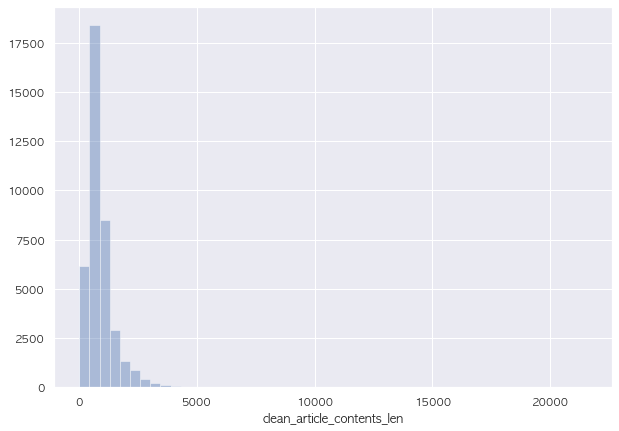

In [1108]:
import seaborn as sns
# 확인해보면, 0-20 사이에 글씨는 없음.
# plt.xlim(0,100)
sns.distplot(final_news_df['clean_article_contents_len'], kde=False, rug=False)

In [1109]:
print(final_news_df[final_news_df['clean_article_contents_len']<=50].shape)
final_news_df[final_news_df['clean_article_contents_len']<=50]

(117, 10)


,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len
117,NB12018521,50,문화,202108021554,2021-08-02 15:54:04.043,[인사] 김천대학교,▲ 김천대학교 교무처장 권창오 ▲김천대학교 입학처장 최준일,"[김천/NNP, 대학교/NNG]",▲ 김천대학교 교무처장 권창오 ▲김천대학교 입학처장 최준일,32
372,NB11993289,10,정치,202102201728,2021-02-20 17:28:32.700,오늘의 주요뉴스,<!-- @ckeditor_contents_s@ -->오늘의 주요뉴스<!-- @ck...,"[오늘/NNG, 주요뉴스/NNP]",오늘의 주요뉴스,8
374,NB12008592,10,정치,202106071552,2021-06-07 15:52:25.513,(예비) 5시 관계장관 브리핑 (현장연결),<!-- @ckeditor_contents_s@ -->(예비) 5시 관계장관 브리핑...,"[관계/NNG, 장관/NNG, 브리핑/NNP]",5시 관계장관 브리핑,11
375,NB12025648,10,정치,202110031713,2021-10-03 17:13:16.630,[뉴스룸] 10/3 헤드라인 VCR_4. 민주당 두번째 슈퍼위크...오늘 윤곽 나올...,[앵커]<br><br><br>[기자]<br><br>,"[민주당/NNP, 슈퍼/NNG, 위크/NNG, 오늘/NNG, 윤곽/NNG]",,0
376,NB12025649,10,정치,202110031713,2021-10-03 17:13:17.863,[뉴스룸] 10/3 헤드라인 VCR_3. '정부 공급대책'에 태릉 유네스코 취소 가...,[앵커]<br><br><br>[기자]<br><br>,"[정부/NNG, 공급/NNG, 대책/NNG, 태릉/NNG, 유네스코/NNG, 취소/...",,0
...,...,...,...,...,...,...,...,...,...,...
33996,NB12035450,30,사회,202111291714,2021-11-29 17:14:09.200,"[속보] 사적모임 축소 검토한다…""추가 논의 거쳐 결정""","<!-- @ckeditor_contents_s@ --><div id=""txtTag5...","[사적모임/NNP, 축소/NNG, 검토/NNG, 추가/NNG, 논의/NNG, 결정/...",사적모임 축소 검토한다 추가 논의 거쳐 결정,24
34575,NB12035880,10,정치,202112021115,2021-12-02 11:14:15.407,[속보] 소상공인 손실보상 하한 50만원…내년 지역화폐 30조원규모 발행,<!-- @ckeditor_contents_s@ -->소상공인 손실보상 하한 50만...,"[소상공인/NNP, 손실/NNG, 보상/NNG, 내년/NNG, 지역/NNG, 화폐/...",소상공인 손실보상 하한 50만원 내년 지역화폐 30조원규모 발행,35
35872,NB12038877,30,사회,202112141926,2021-12-14 15:32:51.530,"[인터뷰] ""지하철이 갑자기 멈출 때 같은 진동 느꼈다""",<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[지하철/NNG, 진동/NNG]",지하철이 갑자기 멈출 때 같은 진동 느껴,22
35934,NB12039024,30,사회,202112151506,2021-12-15 15:06:07.157,"강태중 평가원장, '수능오류 책임' 사퇴…""국민께 사과""","<div class=""jtbc_img"" id=""txtTag550_...","[강태중/NNP, 평가/NNG, 원장/NNG, 수능/NNG, 오류/NNG, 책임/N...",강태중 한국교육과정평가원장. 평가원장 수능오류 책임 사퇴 국민께 사과,38


### 뉴스 본문 처리

In [1110]:
# news_2022_01_df2['article_contents2'] = \
#     news_2022_01_df2['article_contents'].apply(lambda x: \
#                 article_contents_stopwords(
#                                             tokenize(tokenizer, clean_content(x), type='pos'), 
#                                             process_type='pos'
#                                             )
#                  )

final_news_df['article_contents2'] = \
    final_news_df['clean_article_contents'].apply(lambda x: \
                article_contents_stopwords(tokenize(tokenizer, x, type='pos'), process_type='pos'))

In [1111]:
final_news_df.iloc[0].clean_article_contents

'검찰 사망원인 재감정 의뢰 양부모 엄벌 진정서 쇄도 16개월 된 입양아 정인양을 수개월간 학대해 사망에 이르게 한 혐의를 받는 양부모가 이번 주 법정에 선다. 10일 법원에 따르면 서울남부지법 형사13부 는 오는 13일 아동학대처벌법 위반 등 혐의로 구속기소된 양모 장모씨와 아동복지법 위반 등 혐의를 받는 양부 안모씨의 첫 공판을 연다. 장씨는 지난해 6월부터 10월까지 입양한 딸 정인양을 상습 폭행 학대하고 10월 13일 등 부위에 강한 충격을 가해 숨지게 한 혐의로 재판에 넘겨졌다. 그는 또 지난해 3 10월 15차례에 걸쳐 정인양을 집이나 자동차 안에 홀로 방치하거나 유모차가 엘리베이터 벽에 부딪히도록 힘껏 밀어 정서적으로 학대한 혐의 등도 받고 있다. 장씨의 학대 사실과 악화한 정인 양의 건강 상태를 인지하고도 별다른 조처를 하지 않은 남편 안씨도 불구속 상태로 함께 기소됐다. 검찰에 따르면 정인양은 등 쪽에 가해진 강한 충격으로 인한 복부 손상으로 사망한 것으로 조사됐다. 다만 구체적으로 어떤 방법으로 충격이 가해졌는지가 밝혀지지 않아 검찰은 장씨에게 살인이 아닌 아동학대치사 혐의만 적용해 재판에 넘겼다. 하지만 검찰이 최근 전문 부검의들에게 정인양 사망 원인에 관한 재감정을 의뢰함에 따라 살인 혐의가 추가로 적용될지에도 관심이 쏠린다. 살인 혐의가 적용되면 장씨의 형량은 대폭 늘어날 것으로 보인다. 대법원 양형 기준에 따르면 살인죄는 기본 양형이 10 16년으로 가중 요소가 부여되면 무기 이상의 중형도 선고가 가능하다. 반면 아동학대치사의 경우 기본 4 7년 가중 6 10년으로 상대적으로 양형 기준이 낮다. 한편 이 사건이 방송을 통해 재조명되면서 시민들은 재판부에 수백여건의 진정서를 제출하고 검찰청사 앞에 근조 화환을 보내며 장씨의 엄벌을 요구하고 있다. 다만 재판부는 판단에 영향을 미칠 우려가 있다 며 유 무죄 여부를 판단하기 전까지 진정서를 보지 않을 것 이라고 밝혔다.'

In [1112]:
article_contents_stopwords(tokenize(tokenizer, 
                                    final_news_df.iloc[0].clean_article_contents,
                                    type='pos')
                           , process_type='pos')

['검찰/NNG',
 '망원/NNG',
 '감정/NNG',
 '의뢰/NNG',
 '양부모/NNG',
 '엄벌/NNG',
 '진정서/NNG',
 '쇄도/NNG',
 '입양아/NNG',
 '정인양/NNP',
 '수개월/NNG',
 '학대/NNG',
 '사망/NNG',
 '혐의/NNG',
 '양부모/NNG',
 '이번/NNG',
 '주/NNG',
 '법정/NNG',
 '법원/NNG',
 '서울/NNP',
 '남부/NNG',
 '지법/NNG',
 '형사/NNG',
 '아동학대/NNP',
 '처벌/NNG',
 '법/NNG',
 '위반/NNG',
 '혐의/NNG',
 '구속/NNG',
 '기소/NNG',
 '양모/NNG',
 '장모/NNG',
 '아동/NNG',
 '복지/NNG',
 '법/NNG',
 '위반/NNG',
 '혐의/NNG',
 '양부/NNG',
 '안모/NNG',
 '공판/NNG',
 '장/NNP',
 '지난해/NNG',
 '입양/NNG',
 '딸/NNG',
 '정인양/NNP',
 '상습/NNG',
 '폭행/NNG',
 '학대/NNG',
 '부위/NNG',
 '충격/NNG',
 '혐의/NNG',
 '재판/NNG',
 '지난해/NNG',
 '차례/NNG',
 '정인양/NNP',
 '집/NNG',
 '자동차/NNG',
 '안/NNG',
 '방치/NNG',
 '유모차/NNG',
 '엘리베이터/NNG',
 '벽/NNG',
 '정서/NNG',
 '학대/NNG',
 '혐의/NNG',
 '장/NNP',
 '학대/NNG',
 '사실/NNG',
 '악화/NNG',
 '정인/NNG',
 '양/NNG',
 '건강/NNG',
 '상태/NNG',
 '인지/NNG',
 '조처/NNG',
 '남편/NNG',
 '안/NNP',
 '구속/NNG',
 '상태/NNG',
 '기소/NNG',
 '검찰/NNG',
 '정인양/NNP',
 '등/NNG',
 '충격/NNG',
 '복부/NNG',
 '손상/NNG',
 '사망/NNG',
 '조사/NNG',
 '구체/NNG',
 '방법/NNG',
 '충격

In [1113]:
# news_id=='NB12041089'에 대해서 article_contents2 확인 필요
final_news_df[final_news_df.news_id=='NB12041089']

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2
37400,NB12041089,30,사회,202112311938,2021-12-31 18:09:32.677,마트·백화점도 방역패스 의무화…'4명·9시 영업' 2주 더,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[마트/NNG, 백화점/NNG, 방역패스/NNP, 의무화/NNP, 영업/NNG]",코로나와 싸워온 두 번째 해가 저물고 있습니다. 4시간쯤 뒤엔 그 세 번째 해가 시...,693,"[코로나/NNP, 시간/NNG, 시작/NNG, 방역조치/NNP, 발표/NNG, 대형..."


## 뉴스 카테고리 처리 -> 안함

In [742]:
# final_news_df['section_name2'] = \
#     final_news_df['section_name'].apply(lambda x: \
#                 article_title_stopwords(tokenize(tokenizer, x, type='pos'), process_type='pos'))
# final_news_df.tail()

## 임베딩 전, 뉴스 타이틀과 뉴스 본문 합치기

- 뉴스 기사의 특징에 따라 뉴스 제목과 본문을 합칠때 clean_article_contents_len이 30 이하면, 뉴스 제목만 tagged_doc으로 사용

In [1114]:
final_news_df['tagged_doc'] = \
    final_news_df.apply(lambda x: \
                           concat_news_title_and_contents(x['clean_article_contents_len'],
                                                         x['article_title2'],
                                                         x['article_contents2'], 50),axis=1)

In [1115]:
final_news_df.head()

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc
0,NB11987509,0,종합,202101101609,2021-01-10 16:07:08.047,정인이 양부모 13일 첫 재판…살인죄 적용 가능성 주목,"<!-- @ckeditor_contents_s@ -->검찰, 사망원인 재감정 의뢰&...","[정인/NNG, 양부모/NNG, 재판/NNG, 살인죄/NNG, 적용/NNG, 가능/...",검찰 사망원인 재감정 의뢰 양부모 엄벌 진정서 쇄도 16개월 된 입양아 정인양을 수...,958,"[검찰/NNG, 망원/NNG, 감정/NNG, 의뢰/NNG, 양부모/NNG, 엄벌/N...","[정인/NNG, 양부모/NNG, 재판/NNG, 살인죄/NNG, 적용/NNG, 가능/..."
1,NB11992028,0,종합,202102111055,2021-02-11 10:55:29.993,2년만에 결론난 LG·SK 배터리 소송…특허침해 사건은 남아,<!-- @ckeditor_contents_s@ -->LG &quot;SK가 핵심인...,"[결론/NNG, lg/SL, sk/SL, 배터리/NNG, 소송/NNG, 특허/NNG...",lg sk가 핵심인력 76명 빼갔다 주장 국내외 합의 촉구에도 끝내 평행선 lg s...,2771,"[lg/SL, sk/SL, 핵심/NNG, 인력/NNG, 주장/NNG, 국내외/NNG...","[결론/NNG, lg/SL, sk/SL, 배터리/NNG, 소송/NNG, 특허/NNG..."
2,NB11992031,0,종합,202102111216,2021-02-11 12:16:04.310,"연휴 첫날 전국 역·터미널, 재래시장 한산…공항은 북적","<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[연휴/NNG, 첫날/NNG, 전국/NNG, 역/NNG, 터미널/NNG, 재래/NN...",부산역 대합실 평소와 비슷한 인구이동 재래시장도 한적 제주공항 제주행 청주공항 골프...,1395,"[부산역/NNP, 대합실/NNG, 평소/NNG, 인구/NNG, 이동/NNP, 재래시...","[연휴/NNG, 첫날/NNG, 전국/NNG, 역/NNG, 터미널/NNG, 재래/NN..."
3,NB12021784,0,종합,202108291427,2021-08-29 14:27:06.750,"윤석열 첫 공약 발표…""청년에 '원가주택' 공급…LTV 80％로 인상""","<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[윤석열/NNP, 공약/NNG, 발표/NNG, 청년/NNG, 원가/NNG, 주택/N...",국민의힘 대권주자인 윤석열 전 검찰총장은 29일 청년 원가 주택 과 역세권 첫집 주...,1051,"[국민의힘/NNP, 대권주자/NNP, 윤석열/NNP, 검찰/NNG, 총장/NNG, ...","[윤석열/NNP, 공약/NNG, 발표/NNG, 청년/NNG, 원가/NNG, 주택/N..."
4,NB11986923,20,경제,202101061947,2021-01-06 16:19:33.750,신시대일까? 거품일까?｜복마크,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[신시대/NNG, 거품/NNG]",오늘 저희가 밑줄 친 한 줄은 신시대일까 거품일까 입니다. 코스피 지수가 오늘 장중...,326,"[시대/NNG, 거품/NNG, 코스피/NNP, 지수/NNG, 장중/NNG, 처음/N...","[신시대/NNG, 거품/NNG, 시대/NNG, 거품/NNG, 코스피/NNP, 지수/..."


clean_article_contents_len이 짧은 것은 뉴스 타이틀로만 tagged_doc 형성을 확인함

In [1116]:
final_news_df[final_news_df['clean_article_contents_len']<50][['news_id', 'section_name','article_title','clean_article_contents_len', 'tagged_doc']]


,news_id,section_name,article_title,clean_article_contents_len,tagged_doc
117,NB12018521,문화,[인사] 김천대학교,32,"[김천/NNP, 대학교/NNG]"
372,NB11993289,정치,오늘의 주요뉴스,8,"[오늘/NNG, 주요뉴스/NNP]"
374,NB12008592,정치,(예비) 5시 관계장관 브리핑 (현장연결),11,"[관계/NNG, 장관/NNG, 브리핑/NNP]"
375,NB12025648,정치,[뉴스룸] 10/3 헤드라인 VCR_4. 민주당 두번째 슈퍼위크...오늘 윤곽 나올...,0,"[민주당/NNP, 슈퍼/NNG, 위크/NNG, 오늘/NNG, 윤곽/NNG]"
376,NB12025649,정치,[뉴스룸] 10/3 헤드라인 VCR_3. '정부 공급대책'에 태릉 유네스코 취소 가...,0,"[정부/NNG, 공급/NNG, 대책/NNG, 태릉/NNG, 유네스코/NNG, 취소/..."
...,...,...,...,...,...
33996,NB12035450,사회,"[속보] 사적모임 축소 검토한다…""추가 논의 거쳐 결정""",24,"[사적모임/NNP, 축소/NNG, 검토/NNG, 추가/NNG, 논의/NNG, 결정/..."
34575,NB12035880,정치,[속보] 소상공인 손실보상 하한 50만원…내년 지역화폐 30조원규모 발행,35,"[소상공인/NNP, 손실/NNG, 보상/NNG, 내년/NNG, 지역/NNG, 화폐/..."
35872,NB12038877,사회,"[인터뷰] ""지하철이 갑자기 멈출 때 같은 진동 느꼈다""",22,"[지하철/NNG, 진동/NNG]"
35934,NB12039024,사회,"강태중 평가원장, '수능오류 책임' 사퇴…""국민께 사과""",38,"[강태중/NNP, 평가/NNG, 원장/NNG, 수능/NNG, 오류/NNG, 책임/N..."


### 제대로 정제 및 정규화가 되었는지 확인하기

In [1117]:
def remove_pos(tokens):
    result = []
    for t in tokens:
        result.append(t.split("/")[0])
    return result

In [1118]:
final_news_df['doc_remove_pos'] = final_news_df['tagged_doc'].apply(remove_pos)

In [1119]:
final_news_df.columns

Index(['news_id',
       'news_section',
       'section_name',
       'service_dt',
       'reg_dt',
       'article_title',
       'article_contents',
       'article_title2',
       'clean_article_contents',
       'clean_article_contents_len',
       'article_contents2',
       'tagged_doc',
       'doc_remove_pos'],
      dtype='object')

In [1120]:
final_news_df.iloc[-1][['news_id', 'article_title', 'tagged_doc', 'doc_remove_pos']]

news_id                                                  NB12041067
article_title                        [날씨] 아침 최저기온 영하 16도…오후부터 한파 풀려
tagged_doc        [아침/NNG, 최저기온/NNP, 영하/NNG, 오후/NNG, 한파/NNG, 새해/...
doc_remove_pos    [아침, 최저기온, 영하, 오후, 한파, 새해, 첫날, 내일, 오전, 오후, 아침,...
Name: 39319, dtype: object

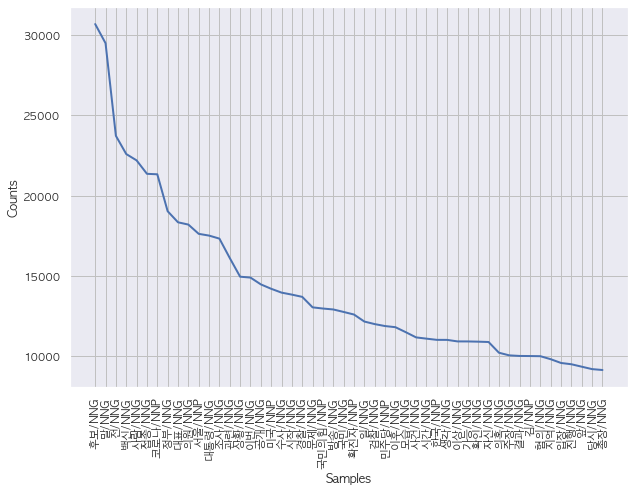

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [1121]:
from nltk.probability import FreqDist
# parsing_df = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "parsing_data_df.pickle"]))

word_split = []
for i in range(final_news_df.shape[0]):
    for j in final_news_df.iloc[i]['tagged_doc']:
        word_split.append(j)

# 사전 업데이트가 조금 필요한 듯 ㅠㅠ
fd_names = FreqDist(word_split)
fd_names.plot(50)

In [1122]:
fd_names.most_common(100)

[('후보/NNG', 30693),
 ('말/NNG', 29501),
 ('전/NNG', 23728),
 ('백신/NNG', 22593),
 ('사람/NNG', 22198),
 ('접종/NNG', 21361),
 ('코로나/NNP', 21331),
 ('정부/NNG', 19029),
 ('대표/NNG', 18339),
 ('의원/NNG', 18197),
 ('서울/NNP', 17620),
 ('대통령/NNG', 17511),
 ('조사/NNG', 17322),
 ('관련/NNG', 16112),
 ('상황/NNG', 14949),
 ('이번/NNG', 14894),
 ('공개/NNG', 14470),
 ('미국/NNP', 14196),
 ('수사/NNG', 13957),
 ('시작/NNG', 13832),
 ('경찰/NNG', 13692),
 ('문제/NNG', 13039),
 ('국민의힘/NNP', 12965),
 ('방송/NNG', 12907),
 ('국민/NNG', 12752),
 ('확진자/NNP', 12591),
 ('일/NNG', 12154),
 ('검찰/NNG', 11995),
 ('민주당/NNP', 11873),
 ('이후/NNG', 11802),
 ('모습/NNG', 11491),
 ('사건/NNG', 11166),
 ('시간/NNG', 11088),
 ('한국/NNP', 11013),
 ('생각/NNG', 11011),
 ('이상/NNG', 10916),
 ('가능/NNG', 10914),
 ('확인/NNG', 10900),
 ('자신/NNG', 10879),
 ('의혹/NNG', 10211),
 ('주장/NNG', 10046),
 ('결과/NNG', 10010),
 ('김/NNP', 10004),
 ('혐의/NNG', 9995),
 ('지역/NNG', 9807),
 ('입장/NNG', 9572),
 ('진행/NNG', 9492),
 ('앞/NNG', 9340),
 ('당시/NNG', 9189),
 ('총장/NNG', 9134),
 ('최근/

In [1123]:
# 전체 단어의 수, '병원/NNG'의 출현 횟수, 확률
fd_names.N(), fd_names['병원/NNG'], fd_names.freq("병원/NNG")

(5870389, 5920, 0.0010084510583540545)

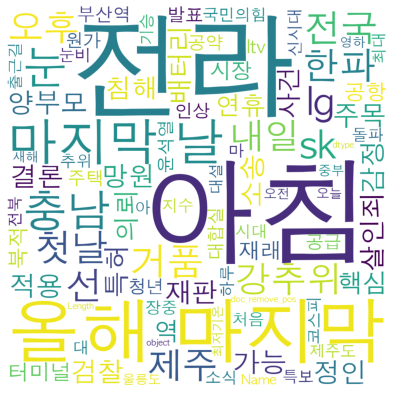

In [1124]:
from wordcloud import WordCloud
# 위와 다르게 wordcloud 안에서는 stopword가 있어서 약간의 차이가 있음
wv = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                 background_color='white', max_words=100, max_font_size=300,
                 width=1000, height=1000)
wv.generate(str(final_news_df['doc_remove_pos']))
plt.imshow(wv)
plt.axis("off")
plt.show()

## doc2vec 모델 생성

### 사전 업데이트에 따른 tagged_doc, tagged_doc2 재생성
- 본문만 클렌징 되었다고 가정 (title은 다시 재처리)

필드 확인 (clean_article_contents_len이 50보다 작으면 순수하게 title만 tagged_doc으로 사용)
- tagged_doc : article_title2 + article_contents2                  => (model) model_w_mecab_tagged_doc.doc2vec
- tagged_doc2 : section_name2 + article_title2 + article_contents2 => (model) model_w_mecab_tagged_doc2.doc2vec

In [1223]:
from doc2vec.preprocessor.preprocessing import *

In [1224]:
tokenizer = get_tokenizer("mecab")

In [1225]:
print(tokenizer.pos('검수완박'))
print(tokenizer.pos('코로나 1년, 코로나와 싸워온 두 번째 해가 저물고 있습니다.'))

[('검수완박', 'NNP')]
[('코로나', 'NNP'), ('1', 'SN'), ('년', 'NNBC'), (',', 'SC'), ('코', 'NNG'), ('로', 'JKB'), ('나와', 'VV+EC'), ('싸워온', 'VV+EC+VX+ETM'), ('두', 'MM'), ('번', 'NNBC'), ('째', 'XSN'), ('해', 'NNG'), ('가', 'JKS'), ('저물', 'VV'), ('고', 'EC'), ('있', 'VX'), ('습니다', 'EF'), ('.', 'SF')]


In [1226]:
final_news_df['article_title2'] = \
    final_news_df['article_title'].apply(lambda x: \
                article_title_stopwords(tokenize(tokenizer, clean_content(remove_title_stopwords(x)), type='pos'), process_type='pos'))
                                                                           

In [1227]:
final_news_df['article_contents2'] = \
    final_news_df['clean_article_contents'].apply(lambda x: \
                article_contents_stopwords(tokenize(tokenizer, x, type='pos'), process_type='pos'))

In [1228]:
# 코로나와 싸워온 두 번째 해가 저물고 있습니다.
# mecab에서 compile을 했는데 코로나가 다음과 같이 된 경우 user-nnp.csv에서 코로나에 대해서만 0으로 변경 -> make clean & make install
final_news_df[final_news_df.news_id=='NB12041089']\
    [['article_title', 'article_title2', 'clean_article_contents', 'article_contents2']]

,article_title,article_title2,clean_article_contents,article_contents2
37399,마트·백화점도 방역패스 의무화…'4명·9시 영업' 2주 더,"[마트/NNG, 백화점/NNG, 방역패스/NNP, 무화/NNG, 영업/NNG]",코로나와 싸워온 두 번째 해가 저물고 있습니다. 4시간쯤 뒤엔 그 세 번째 해가 시...,"[코/NNG, 시간/NNG, 시작/NNG, 방역조치/NNP, 발표/NNG, 대형마트..."


In [1229]:
# 의미 없는 데이터 확인
remove_news_ids = final_news_df[(final_news_df.article_title2.apply(len)<=0)&(final_news_df.clean_article_contents_len<=50)].news_id.values

final_news_df[final_news_df.news_id.isin(remove_news_ids)]

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos


In [1230]:
# 의미 없는 데이터 삭제
remove_news_ids = final_news_df[(final_news_df.article_title2.apply(len)<=0)&(final_news_df.clean_article_contents_len<=50)].news_id.values
final_news_df = final_news_df[~final_news_df.news_id.isin(remove_news_ids)].copy()
final_news_df.reset_index(drop=True, inplace=True)

In [1231]:
# 본문이 50보다 작으면, tagged_doc = article_titlte2
# 본문이 50보다 크면, tagged_doc = article_titlte2 + article_contents2

final_news_df['tagged_doc'] = \
    final_news_df.apply(lambda x: \
                           concat_news_title_and_contents(x['clean_article_contents_len'],
                                                         x['article_title2'],
                                                         x['article_contents2'], 50),axis=1)

In [1232]:
final_news_df['doc_remove_pos'] = final_news_df['tagged_doc'].apply(remove_pos)

In [1158]:
# final_news_df['tagged_doc2'] = \
#     final_news_df.apply(lambda x: \
#                            concat_news_section(x['section_name2'],
#                                                x['tagged_doc']),axis=1)


In [1196]:
final_news_df.shape

(39319, 13)

### 모델에 들어갈 데이터 최종

In [1233]:
save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "final_news_df.pickle"]), final_news_df)

In [506]:
# final_news_df = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "final_news_df.pickle"]))

In [1162]:
final_news_df[final_news_df.article_title.str.find("단독")>=0].shape

(1088, 13)

In [1163]:
final_news_df[final_news_df.article_title.str.find("[인사]")>=0]

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
117,NB12018521,50,문화,202108021554,2021-08-02 15:54:04.043,[인사] 김천대학교,▲ 김천대학교 교무처장 권창오 ▲김천대학교 입학처장 최준일,"[김천/NNP, 대학교/NNG]",▲ 김천대학교 교무처장 권창오 ▲김천대학교 입학처장 최준일,32,"[김천/NNP, 대학교/NNG, 교무/NNG, 처장/NNG, 권창오/NNP, 김천/...","[김천/NNP, 대학교/NNG]","[김천, 대학교]"


In [1164]:
final_news_df[final_news_df.clean_article_contents_len<=50]\
[['news_id', 'article_title', 'article_title2', 'clean_article_contents', 'clean_article_contents_len','tagged_doc']]

,news_id,article_title,article_title2,clean_article_contents,clean_article_contents_len,tagged_doc
117,NB12018521,[인사] 김천대학교,"[김천/NNP, 대학교/NNG]",▲ 김천대학교 교무처장 권창오 ▲김천대학교 입학처장 최준일,32,"[김천/NNP, 대학교/NNG]"
372,NB11993289,오늘의 주요뉴스,"[오늘/NNG, 주요뉴스/NNP]",오늘의 주요뉴스,8,"[오늘/NNG, 주요뉴스/NNP]"
374,NB12008592,(예비) 5시 관계장관 브리핑 (현장연결),"[관계/NNG, 장관/NNG, 브리핑/NNP]",5시 관계장관 브리핑,11,"[관계/NNG, 장관/NNG, 브리핑/NNP]"
375,NB12025648,[뉴스룸] 10/3 헤드라인 VCR_4. 민주당 두번째 슈퍼위크...오늘 윤곽 나올...,"[민주당/NNP, 슈퍼/NNG, 위크/NNG, 오늘/NNG, 윤곽/NNG]",,0,"[민주당/NNP, 슈퍼/NNG, 위크/NNG, 오늘/NNG, 윤곽/NNG]"
376,NB12025649,[뉴스룸] 10/3 헤드라인 VCR_3. '정부 공급대책'에 태릉 유네스코 취소 가...,"[정부/NNG, 공급/NNG, 대책/NNG, 태릉/NNG, 유네스코/NNG, 취소/...",,0,"[정부/NNG, 공급/NNG, 대책/NNG, 태릉/NNG, 유네스코/NNG, 취소/..."
...,...,...,...,...,...,...
33996,NB12035450,"[속보] 사적모임 축소 검토한다…""추가 논의 거쳐 결정""","[사적모임/NNP, 축소/NNG, 검토/NNG, 추가/NNG, 논의/NNG, 결정/...",사적모임 축소 검토한다 추가 논의 거쳐 결정,24,"[사적모임/NNP, 축소/NNG, 검토/NNG, 추가/NNG, 논의/NNG, 결정/..."
34575,NB12035880,[속보] 소상공인 손실보상 하한 50만원…내년 지역화폐 30조원규모 발행,"[소상공인/NNP, 손실/NNG, 보상/NNG, 내년/NNG, 지역/NNG, 화폐/...",소상공인 손실보상 하한 50만원 내년 지역화폐 30조원규모 발행,35,"[소상공인/NNP, 손실/NNG, 보상/NNG, 내년/NNG, 지역/NNG, 화폐/..."
35872,NB12038877,"[인터뷰] ""지하철이 갑자기 멈출 때 같은 진동 느꼈다""","[지하철/NNG, 진동/NNG]",지하철이 갑자기 멈출 때 같은 진동 느껴,22,"[지하철/NNG, 진동/NNG]"
35934,NB12039024,"강태중 평가원장, '수능오류 책임' 사퇴…""국민께 사과""","[강태중/NNP, 평가/NNG, 원장/NNG, 수능/NNG, 오류/NNG, 책임/N...",강태중 한국교육과정평가원장. 평가원장 수능오류 책임 사퇴 국민께 사과,38,"[강태중/NNP, 평가/NNG, 원장/NNG, 수능/NNG, 오류/NNG, 책임/N..."


In [1165]:
# tagged_doc = \
#     generate_tagged_document_by_pandas(final_news_df)
tagged_doc = []
for idx, row in final_news_df.iterrows():
    tagged_doc.append(gensim.models.doc2vec.TaggedDocument(row['tagged_doc'], [row['news_id']]))
print(type(tagged_doc))
print(len(tagged_doc))
tagged_doc[0]

<class 'list'>
39319


TaggedDocument(words=['정인/NNG', '양부모/NNG', '재판/NNG', '살인죄/NNG', '적용/NNG', '가능/NNG', '주목/NNG', '검찰/NNG', '망원/NNG', '감정/NNG', '의뢰/NNG', '양부모/NNG', '엄벌/NNG', '진정서/NNG', '쇄도/NNG', '입양아/NNG', '정인양/NNP', '수개월/NNG', '학대/NNG', '사망/NNG', '혐의/NNG', '양부모/NNG', '이번/NNG', '주/NNG', '법정/NNG', '법원/NNG', '서울/NNP', '남부/NNG', '지법/NNG', '형사/NNG', '아동학대/NNP', '처벌/NNG', '법/NNG', '위반/NNG', '혐의/NNG', '구속/NNG', '기소/NNG', '양모/NNG', '장모/NNG', '아동/NNG', '복지/NNG', '법/NNG', '위반/NNG', '혐의/NNG', '양부/NNG', '안모/NNG', '공판/NNG', '장/NNP', '지난해/NNG', '입양/NNG', '딸/NNG', '정인양/NNP', '상습/NNG', '폭행/NNG', '학대/NNG', '부위/NNG', '충격/NNG', '혐의/NNG', '재판/NNG', '지난해/NNG', '차례/NNG', '정인양/NNP', '집/NNG', '자동차/NNG', '안/NNG', '방치/NNG', '유모차/NNG', '엘리베이터/NNG', '벽/NNG', '정서/NNG', '학대/NNG', '혐의/NNG', '장/NNP', '학대/NNG', '사실/NNG', '악화/NNG', '정인/NNG', '양/NNG', '건강/NNG', '상태/NNG', '인지/NNG', '조처/NNG', '남편/NNG', '안/NNP', '구속/NNG', '상태/NNG', '기소/NNG', '검찰/NNG', '정인양/NNP', '등/NNG', '충격/NNG', '복부/NNG', '손상/NNG', '사망/NNG', '조사/NNG', '구체/NNG', '방법/NNG', 

### 모델 생성

In [883]:
from doc2vec.util.common import load_pickle, save_pickle
# from doc2vec.model.doc2vec import build_model

In [1166]:
import gensim
import multiprocessing
# 아래 FAST_VERSION을 쓰면, 자체적으로 c complier를 사용하여 학습 시킴
from gensim.models.word2vec import FAST_VERSION
def build_model() -> gensim.models.doc2vec.Doc2Vec:
	# using all available CPU cores.
	cores = multiprocessing.cpu_count()

	# https://radimrehurek.com/gensim/models/doc2vec.html
	# vector_size: Dimensionality of the feature vectors
	# window: 앞 뒤로 단어 보는거 (사이즈가 커지면, 훈련 결과로 나오는 word vectors의 성능이 높아지지만, 훈련 시간이 오래 걸림. 보통 5-10)
	# vector_size: 벡터 차원의 크기
	# alpha: learning rate
	# min_count: 학습에 사용할 최소 단어 빈도 수
	# dm: 학습방법 1 = PV-DM, 0 = PV-DBOW (거의 PV-DM이 성능이 더 잘 나옴)
	# negative: Complexity Reduction 방법, negative sampling
	# max_epochs: 최대 학습 횟수
	# 정확도 참고: Dipika Baad의 Doc2Vec 매개변수 조합에 대한 정확도
	# (
	# 	window=10,
	# size=150,
	# alpha=0.025,
	# min_alpha=0.025,
	# min_count=2,
	# dm =1,
	# negative = 5,
	# seed = 9999)
    # vector_size=100, min_count=6, windows=4 -> 논문
	model = gensim.models.doc2vec.Doc2Vec(vector_size=1000, min_count=6, epochs=100,
										  alpha=0.025, min_alpha=0.00025, workers=cores,
										  window=4, dm=1, seed=9999)
	# model = gensim.models.doc2vec.Doc2Vec(vector_size=1000, min_count=2, epochs=100,
	# 									  alpha=0.025, min_alpha=0.00025, workers=cores,
	# 									  window=15, sampling_threshold=1e-5, negative_size=5, dm=1, seed=9999)

	print(type(model))

	return model

In [1169]:
len(tagged_doc)

39319

In [1170]:
d2v_model = build_model()

# 사전 구축
d2v_model.build_vocab(tagged_doc)

# 모델 훈련
d2v_model.train(tagged_doc, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

d2v_model.save(os.path.join(rootpath.detect(), *['model', 'model_w_mecab_tagged_doc.doc2vec']))

2022-05-04 15:46:06,991 [INFO] - utils.py:add_lifecycle_event - line:447 - Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d1000,n5,w4,mc6,s0.001,t12)', 'datetime': '2022-05-04T15:46:06.991290', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:48:00) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'created'}
2022-05-04 15:46:07,127 [INFO] - doc2vec.py:scan_vocab - line:1044 - collecting all words and their counts
2022-05-04 15:46:07,139 [INFO] - doc2vec.py:_scan_vocab - line:961 - PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags


<class 'gensim.models.doc2vec.Doc2Vec'>


2022-05-04 15:46:08,321 [INFO] - doc2vec.py:_scan_vocab - line:961 - PROGRESS: at example #10000, processed 1484482 words (1262005/s), 37448 word types, 10000 tags
2022-05-04 15:46:09,647 [INFO] - doc2vec.py:_scan_vocab - line:961 - PROGRESS: at example #20000, processed 2984480 words (1133487/s), 51362 word types, 20000 tags
2022-05-04 15:46:11,104 [INFO] - doc2vec.py:_scan_vocab - line:961 - PROGRESS: at example #30000, processed 4497566 words (1040358/s), 59992 word types, 30000 tags
2022-05-04 15:46:13,127 [INFO] - doc2vec.py:scan_vocab - line:1050 - collected 66475 word types and 39319 unique tags from a corpus of 39319 examples and 5870494 words
2022-05-04 15:46:13,136 [INFO] - word2vec.py:prepare_vocab - line:633 - Creating a fresh vocabulary
2022-05-04 15:46:13,559 [INFO] - utils.py:add_lifecycle_event - line:447 - Doc2Vec lifecycle event {'msg': 'effective_min_count=6 retains 30777 unique words (46.29860849943588%% of original 66475, drops 35698)', 'datetime': '2022-05-04T15:4

2022-05-04 15:46:42,825 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 1 - PROGRESS: at 100.00% examples, 217888 words/s, in_qsize 0, out_qsize 1
2022-05-04 15:46:42,827 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 15:46:42,829 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 1 : training on 5870494 raw words (5776439 effective words) took 26.5s, 217854 effective words/s
2022-05-04 15:46:43,893 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 2 - PROGRESS: at 2.55% examples, 130954 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:46:44,944 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 2 - PROGRESS: at 6.80% examples, 172679 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:46:45,957 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 2 - PROGRESS: at 10.81% examples, 191412 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:46:46,983 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:47:25,395 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 59.52% examples, 213003 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:47:26,426 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 63.09% examples, 213247 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:47:27,478 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 67.07% examples, 213742 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:47:28,557 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 71.55% examples, 213904 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:47:29,626 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 74.58% examples, 213167 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:47:30,695 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 78.35% examples, 212973 words/s, in_qsize 24, out_qsize 1
2022-05-04 15:47:31,865 [INFO] - word2vec.py:_log_progress - line:1585 - EPO

2022-05-04 15:48:02,165 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 15:48:02,183 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 15:48:02,222 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 15:48:02,228 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 15:48:02,251 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 15:48:02,255 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 4 : training on 5870494 raw words (5776382 effective words) took 26.0s, 222092 effective words/s
2022-05-04 15:48:03,282 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 3.03% examples, 164855 words/s, in_qsize

2022-05-04 15:48:41,843 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 46.87% examples, 211544 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:48:42,846 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 50.64% examples, 213071 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:48:43,952 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 54.62% examples, 212865 words/s, in_qsize 22, out_qsize 1
2022-05-04 15:48:45,027 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 59.02% examples, 213222 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:48:46,085 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 62.74% examples, 213682 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:48:47,146 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 66.80% examples, 214057 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:48:48,228 [INFO] - word2vec.py:_log_progress - line:1585 - EPO

2022-05-04 15:49:21,095 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 15:49:21,207 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 15:49:21,235 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 15:49:21,248 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 15:49:21,280 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 15:49:21,325 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 15:49:21,347 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 15:49:21,350 [INFO] - word2vec

2022-05-04 15:49:58,093 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 38.77% examples, 212047 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:49:59,139 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 42.83% examples, 213900 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:50:00,168 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 46.67% examples, 214216 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:50:01,203 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 50.50% examples, 215017 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:50:02,294 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 54.62% examples, 215560 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:50:03,310 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 58.64% examples, 215286 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:50:04,348 [INFO] - word2vec.py:_log_progress - line:1585 - EPO

2022-05-04 15:50:39,137 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 15:50:39,183 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 15:50:39,202 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 15:50:39,328 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 15:50:39,376 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 15:50:39,402 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 15:50:39,417 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 15:50:39,455 [INFO] - word2vec

2022-05-04 15:51:14,451 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 38.91% examples, 213221 words/s, in_qsize 23, out_qsize 1
2022-05-04 15:51:15,451 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 42.95% examples, 215824 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:51:16,522 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 47.30% examples, 217503 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:51:17,527 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 51.83% examples, 220820 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:51:18,549 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 56.19% examples, 222622 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:51:19,660 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 12 - PROGRESS: at 60.79% examples, 223659 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:51:20,702 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:51:53,591 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 15:51:53,659 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 15:51:53,668 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 15:51:53,683 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 15:51:53,735 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 15:51:53,754 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 15:51:53,775 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 15:51:53,783 [INFO] - word2vec

2022-05-04 15:52:30,207 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 47.30% examples, 233390 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:52:31,224 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 51.08% examples, 232343 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:52:32,273 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 55.43% examples, 232941 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:52:33,290 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 59.95% examples, 234119 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:52:34,309 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 63.99% examples, 235037 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:52:35,337 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 67.66% examples, 232794 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:52:36,369 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:53:07,573 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 15:53:07,590 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 15:53:07,601 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 15:53:07,640 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 15:53:07,709 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 15:53:07,736 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 15:53:07,739 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 16 : training on 5870494 raw words (5776428 effective words) took 24.4s, 236729 effective words/

2022-05-04 15:53:45,791 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 54.01% examples, 232232 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:53:46,798 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 57.64% examples, 230222 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:53:47,806 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 62.23% examples, 232211 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:53:48,818 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 65.86% examples, 232144 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:53:49,820 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 70.50% examples, 231096 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:53:50,865 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 74.40% examples, 233240 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:53:51,890 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:54:21,013 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 15:54:21,019 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 15:54:21,032 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 15:54:21,034 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 19 : training on 5870494 raw words (5776326 effective words) took 24.2s, 238493 effective words/s
2022-05-04 15:54:22,057 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 20 - PROGRESS: at 3.34% examples, 174389 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:54:23,087 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 20 - PROGRESS: at 7.84% examples, 206440 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:54:24,136 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 20 - PROGRESS: at 12.3

2022-05-04 15:55:01,985 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 69.45% examples, 240802 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:55:03,006 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 73.50% examples, 241706 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:55:04,014 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 77.15% examples, 241158 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:05,023 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 81.79% examples, 242157 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:06,024 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 85.67% examples, 241204 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:07,049 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 21 - PROGRESS: at 89.87% examples, 240986 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:08,119 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:55:33,974 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 22 : training on 5870494 raw words (5776362 effective words) took 24.6s, 234860 effective words/s
2022-05-04 15:55:34,995 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 4.09% examples, 213815 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:35,998 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 8.60% examples, 228446 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:37,178 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 12.61% examples, 222733 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:55:38,202 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 16.70% examples, 230746 words/s, in_qsize 23, out_qsize 1
2022-05-04 15:55:39,207 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 20.87% examples, 233002 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:55:40,214 [INFO] - word2vec.py:_l

2022-05-04 15:56:17,422 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 77.65% examples, 238422 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:18,466 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 82.07% examples, 238608 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:19,474 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 86.00% examples, 237788 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:20,480 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 90.17% examples, 237932 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:21,489 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 94.55% examples, 238067 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:22,298 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 15:56:22,315 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker t

2022-05-04 15:56:48,961 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 7.33% examples, 194174 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:49,999 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 10.83% examples, 195023 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:51,009 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 15.04% examples, 213285 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:52,010 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 18.91% examples, 217085 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:53,016 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 23.10% examples, 217958 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:56:54,044 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 27.26% examples, 220584 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:56:55,068 [INFO] - word2vec.py:_log_progress - line:1585 

2022-05-04 15:57:32,657 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 82.63% examples, 230340 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:57:33,665 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 86.65% examples, 230356 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:57:34,674 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 90.81% examples, 230800 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:57:35,676 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 95.21% examples, 231306 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:57:36,229 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 15:57:36,238 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 15:57:36,241 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; a

2022-05-04 15:58:05,199 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 18.91% examples, 241090 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:58:06,216 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 24.12% examples, 247792 words/s, in_qsize 24, out_qsize 1
2022-05-04 15:58:07,395 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 28.62% examples, 243214 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:58:08,413 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 32.42% examples, 242755 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:58:09,420 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 36.81% examples, 241564 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:58:10,430 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 41.83% examples, 244532 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:58:11,435 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 15:58:48,483 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 15:58:48,520 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 15:58:48,523 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 15:58:48,599 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 98.36% examples, 235660 words/s, in_qsize 7, out_qsize 1
2022-05-04 15:58:48,611 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 15:58:48,616 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 15:58:48,653 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 15:58:48,664

2022-05-04 15:59:21,189 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 30.30% examples, 238909 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:59:22,209 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 34.56% examples, 237678 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:59:23,335 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 39.09% examples, 235237 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:59:24,383 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 43.23% examples, 235800 words/s, in_qsize 23, out_qsize 1
2022-05-04 15:59:25,411 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 47.44% examples, 235805 words/s, in_qsize 24, out_qsize 0
2022-05-04 15:59:26,429 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 32 - PROGRESS: at 51.25% examples, 234562 words/s, in_qsize 23, out_qsize 0
2022-05-04 15:59:27,466 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:00:02,544 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:00:02,616 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:00:02,664 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:00:02,689 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:00:02,762 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:00:02,809 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:00:02,824 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:00:02,856 [INFO] - word2vec

2022-05-04 16:00:37,928 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 41.83% examples, 229402 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:00:38,957 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 45.57% examples, 228327 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:00:39,968 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 49.63% examples, 229265 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:00:40,994 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 53.41% examples, 227720 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:00:42,032 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 57.14% examples, 226812 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:00:43,057 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 35 - PROGRESS: at 61.21% examples, 226258 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:00:44,066 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:01:17,202 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:01:17,232 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:01:17,271 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:01:17,280 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:01:17,320 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:01:17,347 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:01:17,360 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:01:17,383 [INFO] - word2vec

2022-05-04 16:01:51,134 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 42.95% examples, 220017 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:01:52,166 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 47.18% examples, 221273 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:01:53,240 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 50.64% examples, 219512 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:01:54,278 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 54.62% examples, 219856 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:01:55,307 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 59.02% examples, 220384 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:01:56,350 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 38 - PROGRESS: at 62.92% examples, 221191 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:01:57,394 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:02:29,671 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:02:29,727 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:02:29,809 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:02:29,814 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:02:29,824 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:02:29,842 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:02:29,845 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:02:29,849 [INFO] - word2vec

2022-05-04 16:03:06,348 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 47.18% examples, 237570 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:03:07,432 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 51.48% examples, 237256 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:03:08,436 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 55.97% examples, 238993 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:03:09,467 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 60.27% examples, 238835 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:03:10,622 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 64.50% examples, 238623 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:03:11,632 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 41 - PROGRESS: at 69.21% examples, 238192 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:03:12,633 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:03:43,543 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:03:43,594 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:03:43,629 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:03:43,646 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:03:43,659 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:03:43,694 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:03:43,698 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 42 : training on 5870494 raw words (5776530 effective words) took 24.9s, 232107 effective words/

2022-05-04 16:04:21,848 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 62.11% examples, 242310 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:04:22,897 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 65.91% examples, 241629 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:04:23,956 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 71.08% examples, 241482 words/s, in_qsize 23, out_qsize 2
2022-05-04 16:04:25,080 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 75.45% examples, 243116 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:04:26,097 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 79.60% examples, 243389 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:04:27,153 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 84.14% examples, 243612 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:04:28,154 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:04:54,584 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 45 : training on 5870494 raw words (5776070 effective words) took 23.8s, 242668 effective words/s
2022-05-04 16:04:55,619 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 4.02% examples, 203487 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:04:56,641 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 8.17% examples, 216360 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:04:57,819 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 12.67% examples, 221811 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:04:58,854 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 17.05% examples, 233662 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:04:59,861 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 21.15% examples, 235211 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:05:00,930 [INFO] - word2vec.py:_l

2022-05-04 16:05:37,369 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 74.75% examples, 232650 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:05:38,369 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 79.19% examples, 234167 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:05:39,384 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 83.80% examples, 235810 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:05:40,423 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 88.27% examples, 236166 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:05:41,444 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 92.65% examples, 236235 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:05:42,488 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 97.09% examples, 236489 words/s, in_qsize 16, out_qsize 0
2022-05-04 16:05:42,601 [INFO] - word2vec.py:_log_epoch_progress - lin

2022-05-04 16:06:10,315 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 12.61% examples, 222403 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:11,320 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 16.57% examples, 229228 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:12,411 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 20.74% examples, 228063 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:13,429 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 25.41% examples, 231366 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:06:14,446 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 30.00% examples, 237748 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:15,449 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 33.97% examples, 235983 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:16,459 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:06:54,180 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 93.22% examples, 238819 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:06:55,188 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 97.65% examples, 239737 words/s, in_qsize 12, out_qsize 0
2022-05-04 16:06:55,200 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:06:55,207 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:06:55,258 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:06:55,279 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:06:55,313 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-04 16:07:25,897 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 25.74% examples, 233260 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:07:27,011 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 30.14% examples, 234933 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:07:28,056 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 34.29% examples, 233503 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:07:29,148 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 38.77% examples, 231351 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:07:30,174 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 42.95% examples, 232816 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:07:31,180 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 52 - PROGRESS: at 46.87% examples, 231894 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:07:32,197 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:08:08,467 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:08:08,483 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:08:08,486 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:08:08,568 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:08:08,667 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:08:08,703 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:08:08,746 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:08:08,751 [INFO] - word2ve

2022-05-04 16:08:42,545 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 45.21% examples, 247367 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:43,546 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 49.77% examples, 249492 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:44,607 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 54.23% examples, 250027 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:45,648 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 58.83% examples, 248843 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:46,670 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 62.74% examples, 248080 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:47,683 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 55 - PROGRESS: at 67.28% examples, 248806 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:08:48,764 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:09:18,375 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:09:18,399 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:09:18,425 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:09:18,430 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:09:18,435 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:09:18,437 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 56 : training on 5870494 raw words (5776152 effective words) took 23.3s, 247755 effective words/s
2022-05-04 16:09:19,460 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 4.32% examples, 221580 words/s, in_qsi

2022-05-04 16:09:57,999 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 64.50% examples, 238648 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:09:59,047 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 69.17% examples, 237665 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:00,050 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 73.89% examples, 241191 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:01,054 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 77.82% examples, 241260 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:02,120 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 82.43% examples, 241504 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:03,266 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 58 - PROGRESS: at 86.45% examples, 239408 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:04,302 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:10:30,025 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 59 : training on 5870494 raw words (5776433 effective words) took 23.9s, 241657 effective words/s
2022-05-04 16:10:31,075 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 3.45% examples, 180277 words/s, in_qsize 21, out_qsize 2
2022-05-04 16:10:32,093 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 7.66% examples, 200297 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:10:33,108 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 12.36% examples, 226067 words/s, in_qsize 24, out_qsize 1
2022-05-04 16:10:34,112 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 16.14% examples, 229735 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:35,306 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 20.28% examples, 223756 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:10:36,376 [INFO] - word2vec.py:_l

2022-05-04 16:11:12,746 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 61 - PROGRESS: at 77.81% examples, 242194 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:11:13,843 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 61 - PROGRESS: at 82.43% examples, 242014 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:14,852 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 61 - PROGRESS: at 86.78% examples, 242403 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:15,928 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 61 - PROGRESS: at 91.12% examples, 242012 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:17,005 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 61 - PROGRESS: at 96.62% examples, 243787 words/s, in_qsize 19, out_qsize 0
2022-05-04 16:11:17,350 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:11:17,376 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker t

2022-05-04 16:11:45,157 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 15.18% examples, 215164 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:46,158 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 18.91% examples, 216704 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:11:47,205 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 23.10% examples, 216176 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:11:48,210 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 27.76% examples, 223877 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:49,224 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 31.91% examples, 228280 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:11:50,276 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 36.30% examples, 227609 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:11:51,396 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:12:29,449 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 64 - PROGRESS: at 90.81% examples, 231200 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:12:30,452 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 64 - PROGRESS: at 95.22% examples, 231663 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:12:31,049 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:12:31,087 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:12:31,112 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:12:31,137 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:12:31,153 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-04 16:13:02,271 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 24.76% examples, 226518 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:13:03,275 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 29.02% examples, 229917 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:13:04,287 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 33.55% examples, 234824 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:13:05,309 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 37.56% examples, 232041 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:13:06,328 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 42.14% examples, 233678 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:13:07,330 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 46.25% examples, 235327 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:13:08,352 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:13:45,503 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:13:45,559 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:13:45,594 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:13:45,635 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:13:45,693 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:13:45,741 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:13:45,772 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:13:45,814 [INFO] - word2v

2022-05-04 16:14:18,584 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 36.47% examples, 246684 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:19,619 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 41.21% examples, 246534 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:20,638 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 45.21% examples, 245742 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:21,665 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 49.09% examples, 243222 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:22,679 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 53.21% examples, 242978 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:23,696 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 56.99% examples, 241220 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:14:24,750 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:14:57,391 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:14:57,398 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:14:57,440 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:14:57,472 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:14:57,488 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:14:57,490 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:14:57,500 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:14:57,502 [INFO] - word2vec

2022-05-04 16:15:34,677 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 57.03% examples, 240952 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:15:35,690 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 61.83% examples, 242934 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:15:36,750 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 66.69% examples, 245136 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:15:37,812 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 71.42% examples, 244671 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:15:38,816 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 74.95% examples, 244539 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:15:39,827 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 72 - PROGRESS: at 79.46% examples, 245867 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:15:40,877 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:16:08,669 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:16:08,687 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:16:08,690 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 73 : training on 5870494 raw words (5776467 effective words) took 24.1s, 239403 effective words/s
2022-05-04 16:16:09,737 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 74 - PROGRESS: at 3.73% examples, 190552 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:16:10,759 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 74 - PROGRESS: at 7.81% examples, 205164 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:11,778 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 74 - PROGRESS: at 12.51% examples, 228913 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:12,894 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 74 -

2022-05-04 16:16:50,645 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 72.88% examples, 239042 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:51,674 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 76.86% examples, 239403 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:52,734 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 80.60% examples, 237879 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:53,746 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 85.20% examples, 238445 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:16:54,780 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 88.95% examples, 237786 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:16:55,810 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 75 - PROGRESS: at 93.56% examples, 237721 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:16:56,760 [INFO] - word2vec.py:_log_epoch_progress - lin

2022-05-04 16:17:22,222 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 3.44% examples, 183754 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:17:23,225 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 7.99% examples, 213709 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:17:24,249 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 12.36% examples, 228096 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:17:25,298 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 16.30% examples, 231129 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:17:26,307 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 20.43% examples, 232979 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:17:27,312 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 77 - PROGRESS: at 25.07% examples, 236055 words/s, in_qsize 22, out_qsize 0
2022-05-04 16:17:28,377 [INFO] - word2vec.py:_log_progress - line:1585 -

2022-05-04 16:18:06,033 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 78 - PROGRESS: at 83.46% examples, 236659 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:18:07,118 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 78 - PROGRESS: at 88.26% examples, 237373 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:08,170 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 78 - PROGRESS: at 92.65% examples, 237052 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:09,193 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 78 - PROGRESS: at 96.75% examples, 236667 words/s, in_qsize 18, out_qsize 0
2022-05-04 16:18:09,484 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:18:09,493 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:18:09,515 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; a

2022-05-04 16:18:38,229 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 16.14% examples, 229277 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:39,398 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 20.28% examples, 224412 words/s, in_qsize 24, out_qsize 1
2022-05-04 16:18:40,445 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 25.23% examples, 230378 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:41,512 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 29.31% examples, 229943 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:42,552 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 32.99% examples, 228161 words/s, in_qsize 24, out_qsize 1
2022-05-04 16:18:43,590 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 37.37% examples, 227862 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:18:44,609 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:19:22,477 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-04 16:19:22,506 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-04 16:19:22,514 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-04 16:19:22,529 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:19:22,568 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:19:22,699 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:19:22,711 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:19:22,763 [INFO] - word2v

2022-05-04 16:19:55,625 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 33.17% examples, 232548 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:19:56,635 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 38.15% examples, 235588 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:19:57,643 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 42.42% examples, 236163 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:19:58,658 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 46.81% examples, 238185 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:19:59,838 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 51.08% examples, 235901 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:20:00,874 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 55.44% examples, 236466 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:20:01,937 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:20:35,548 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-04 16:20:35,561 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:20:35,623 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:20:35,699 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:20:35,706 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:20:35,731 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:20:35,751 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:20:35,757 [INFO] - word2vec

2022-05-04 16:21:10,408 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 38.91% examples, 235800 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:21:11,427 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 43.09% examples, 237011 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:21:12,429 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 47.30% examples, 237433 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:21:13,435 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 51.48% examples, 237838 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:21:14,468 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 55.81% examples, 238294 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:21:15,534 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 60.27% examples, 238285 words/s, in_qsize 24, out_qsize 1
2022-05-04 16:21:16,628 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:21:49,151 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:21:49,178 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:21:49,210 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:21:49,227 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:21:49,232 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:21:49,277 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:21:49,337 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:21:49,344 [INFO] - word2vec

2022-05-04 16:22:25,664 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 45.40% examples, 225208 words/s, in_qsize 23, out_qsize 1
2022-05-04 16:22:26,666 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 49.61% examples, 227345 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:22:27,686 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 53.33% examples, 226044 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:22:28,694 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 57.30% examples, 226395 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:22:29,696 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 61.37% examples, 226212 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:22:30,757 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 65.38% examples, 227622 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:22:31,799 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:23:03,514 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:23:03,536 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:23:03,546 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:23:03,588 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:23:03,593 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:23:03,632 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:23:03,634 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 90 : training on 5870494 raw words (5776135 effective words) took 24.5s, 236000 effective words/

2022-05-04 16:23:41,838 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 51.81% examples, 220408 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:23:42,858 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 55.96% examples, 221617 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:23:43,859 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 60.11% examples, 222433 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:23:44,862 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 64.26% examples, 224841 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:23:45,862 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 67.85% examples, 223085 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:23:46,865 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 72.14% examples, 224144 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:23:47,896 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:24:18,767 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:24:18,811 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:24:18,815 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:24:18,818 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:24:18,848 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:24:18,875 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:24:18,877 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 93 : training on 5870494 raw words (5775958 effective words) took 25.0s, 231089 effective words/

2022-05-04 16:24:56,618 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 47.61% examples, 222703 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:24:57,686 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 51.98% examples, 223870 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:24:58,709 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 56.17% examples, 224807 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:24:59,834 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 60.43% examples, 224237 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:25:00,880 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 64.37% examples, 225349 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:25:01,902 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 68.65% examples, 224991 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:25:02,942 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:25:35,413 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-04 16:25:35,457 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-04 16:25:35,504 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:25:35,530 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:25:35,553 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:25:35,583 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:25:35,615 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:25:35,621 [INFO] - word2vec

2022-05-04 16:26:11,382 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 41.76% examples, 229300 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:26:12,470 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 45.82% examples, 228770 words/s, in_qsize 24, out_qsize 1
2022-05-04 16:26:13,485 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 49.76% examples, 228837 words/s, in_qsize 23, out_qsize 0
2022-05-04 16:26:14,549 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 53.91% examples, 228828 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:26:15,571 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 58.03% examples, 228755 words/s, in_qsize 24, out_qsize 0
2022-05-04 16:26:16,584 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 62.32% examples, 230133 words/s, in_qsize 22, out_qsize 1
2022-05-04 16:26:17,611 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-04 16:26:49,543 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-04 16:26:49,595 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 98.95% examples, 238216 words/s, in_qsize 4, out_qsize 1
2022-05-04 16:26:49,600 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-04 16:26:49,643 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-04 16:26:49,658 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-04 16:26:49,670 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-04 16:26:49,673 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-04 16:26:49,677 

### 모델 확인

In [1171]:
# d2v_model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(rootpath.detect(), *['model', 'model_w_mecab_tagged_doc.doc2vec']))

print(tagged_doc[0])
vector = d2v_model.infer_vector(tagged_doc[0].words)
print("vector size = ", len(vector))
print("Top 10 values in Doc2Vec inferred vecotr: ")
print(vector[:10])

print('d2v_model의 문서 수: ', d2v_model.corpus_count) # d2v_model.dv.vectors.shape[0]
print('d2v_model의 단어 수: ', d2v_model.corpus_total_words)
print('d2v_model에 NB12045107 tag가 포함되어 있나? ', d2v_model.dv.has_index_for('NB12045107'), 
      ' ---> is in pandas? ','NB12045107' in unique_news_ids)

print('d2v_model에 NB12041104 tag가 포함되어 있나? ', d2v_model.dv.has_index_for('NB12041104'), 
      ' ---> is in pandas? ','NB12041104' in unique_news_ids)
# print('수술 단어가 모델에 훈련된 빈도 수 : ', d2v_model.wv.get_vecattr('수술', 'count'))
all_docvecs = d2v_model.dv.vectors
print('d2v_model의 vector_size: ', all_docvecs.shape[1])

TaggedDocument(['정인/NNG', '양부모/NNG', '재판/NNG', '살인죄/NNG', '적용/NNG', '가능/NNG', '주목/NNG', '검찰/NNG', '망원/NNG', '감정/NNG', '의뢰/NNG', '양부모/NNG', '엄벌/NNG', '진정서/NNG', '쇄도/NNG', '입양아/NNG', '정인양/NNP', '수개월/NNG', '학대/NNG', '사망/NNG', '혐의/NNG', '양부모/NNG', '이번/NNG', '주/NNG', '법정/NNG', '법원/NNG', '서울/NNP', '남부/NNG', '지법/NNG', '형사/NNG', '아동학대/NNP', '처벌/NNG', '법/NNG', '위반/NNG', '혐의/NNG', '구속/NNG', '기소/NNG', '양모/NNG', '장모/NNG', '아동/NNG', '복지/NNG', '법/NNG', '위반/NNG', '혐의/NNG', '양부/NNG', '안모/NNG', '공판/NNG', '장/NNP', '지난해/NNG', '입양/NNG', '딸/NNG', '정인양/NNP', '상습/NNG', '폭행/NNG', '학대/NNG', '부위/NNG', '충격/NNG', '혐의/NNG', '재판/NNG', '지난해/NNG', '차례/NNG', '정인양/NNP', '집/NNG', '자동차/NNG', '안/NNG', '방치/NNG', '유모차/NNG', '엘리베이터/NNG', '벽/NNG', '정서/NNG', '학대/NNG', '혐의/NNG', '장/NNP', '학대/NNG', '사실/NNG', '악화/NNG', '정인/NNG', '양/NNG', '건강/NNG', '상태/NNG', '인지/NNG', '조처/NNG', '남편/NNG', '안/NNP', '구속/NNG', '상태/NNG', '기소/NNG', '검찰/NNG', '정인양/NNP', '등/NNG', '충격/NNG', '복부/NNG', '손상/NNG', '사망/NNG', '조사/NNG', '구체/NNG', '방법/NNG', '충격/NN

### tagged_doc을 바탕으로 ranking 정보 확인

- 2주에 해당하는 뉴스 생산 건수는 대략 1600건임.
- 1600건을 가지고 doc2vec을 하면, 유사도가 잘 안나옴 (예전에 8000개 정도부터는 그럭저럭 나옴)

In [1172]:
tagged_doc[-1]

TaggedDocument(words=['아침/NNG', '최저기온/NNP', '영하/NNG', '오후/NNG', '한파/NNG', '새해/NNG', '첫날/NNG', '내일/NNG', '오전/NNG', '오후/NNG', '아침/NNG', '기온/NNG', '영하/NNG', '영하/NNG', '낮/NNG', '기온/NNG', '영상/NNG', '일요일/NNG', '서쪽/NNG', '지방/NNG', '중심/NNG', '새벽/NNG', '눈/NNG', '추위/NNG', '예보/NNG'], tags=['NB12041067'])

In [1173]:
# d2v_model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(rootpath.detect(), *['model', 'model_w_mecab.doc2vec']))
# tagged_doc = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "tagged_doc_w_mecab.pickle"]))

ranks = []
for index in tqdm(range(len(tagged_doc)), desc="progress...", mininterval=1):
    time.sleep(0.1)
    a_data = tagged_doc[index]
#     print(a_data)
    selected_news_id = a_data.tags[0]
#     print("news_id: ", selected_news_id)

    inferred = d2v_model.infer_vector(a_data.words)
    # sims = d2v_model.dv.most_similar(inferred, topn=len(d2v_model.dv))
    sims = d2v_model.dv.most_similar(positive=[inferred], topn=100)

    rank = [a_news_id for a_news_id, sim in sims].index(selected_news_id)
    ranks.append(rank)
#     print("-"*100)

import collections
counter = collections.Counter(ranks)
print(counter)

progress...: 100%|██████████| 39319/39319 [1:47:56<00:00,  6.07it/s]

Counter({0: 39197, 1: 94, 2: 11, 4: 7, 3: 5, 5: 3, 6: 2})


In [1174]:
other_ranking = 0
for k, v in counter.items():
    if k != 0:
        other_ranking+=v
print(other_ranking)

122


단순 자기 자신이 제일 많이 나왔는지로만 비교한 결과
- 99.5%의 accuracy가 나옴

In [1175]:
print("전체 rank 0", f"{counter.get(0)}/{final_news_df.shape[0]}", 
      " -> ",  (final_news_df.shape[0]-other_ranking)/final_news_df.shape[0])

print("전체 rank others", f"{other_ranking}/{final_news_df.shape[0]}", 
      " -> ",  (other_ranking)/final_news_df.shape[0])

전체 rank 0 39197/39319  ->  0.9968971743940589
전체 rank others 122/39319  ->  0.003102825605941148


In [1176]:
import numpy as np
not_first_selected_news_ids = []
data = np.array(ranks)

sorted_counter = sorted(counter.items())

# for k, v in sorted_counter.items():
for a_data in sorted_counter:
#     print(k, v)
#     if k!= 0:
    if a_data[0]!=0:
#         not_selecteds = list(np.where(data==k))[0]      
        not_selecteds = list(np.where(data==a_data[0]))[0]      
        not_first_selected_news_ids.extend(not_selecteds)
#         print(f'rank=={k}: ',not_selecteds)
        print(f"rank=={a_data[0]}", not_selecteds)
print("final: ", not_first_selected_news_ids)

rank==1 [   33   171   703  1946  2131  2918  3462  6091  6588  6598  9753 10124
 11178 11232 12307 12348 13101 14823 15545 16255 18348 18807 19174 19186
 20044 21069 21117 21162 23271 24865 24898 25135 25246 25274 26288 26325
 27920 28058 29217 29755 30039 30092 30096 30097 30099 30101 30102 30103
 30104 30107 30108 30111 30114 30115 30116 30118 30130 30717 32397 32399
 32407 32408 32410 32417 32421 32423 32435 32436 32456 32469 32471 32472
 32474 32484 32639 33110 33116 33123 33152 33168 33169 33180 33183 33187
 33194 33196 33199 33200 33209 33210 33218 33220 33226 33227]
rank==2 [ 3126 30038 30105 30120 30132 33115 33188 33216 33217 37362 37365]
rank==3 [30122 33182 33195 33197 33201]
rank==4 [ 2971 30121 30123 30125 30131 33179 33193]
rank==5 [30126 30127 30133]
rank==6 [30124 30128]
final:  [33, 171, 703, 1946, 2131, 2918, 3462, 6091, 6588, 6598, 9753, 10124, 11178, 11232, 12307, 12348, 13101, 14823, 15545, 16255, 18348, 18807, 19174, 19186, 20044, 21069, 21117, 21162, 23271, 2486

In [1177]:
not_ranking_news_id = 15154

In [1178]:
final_news_df.iloc[not_ranking_news_id].article_title

'오늘의 주요뉴스'

In [1179]:
final_news_df.iloc[not_ranking_news_id].article_contents

"<!-- @ckeditor_contents_s@ --><div id='div_NV10435378' class='jtbc_vod'></div>1. 문 정부 마지막 검찰총장 후보자 김오수<br /><br />박상기&middot;조국&middot;추미애 전 법무부 장관 시절을 함께 했던 김오수 전 법무부 차관이, 현 정부의 마지막 검찰총장 후보자로 지명됐습니다. 청와대는 &quot;적극적인 소통으로 검찰을 안정시키고, &#39;검찰개혁&#39;이라는 시대적 소임을 다해줄 것으로 기대한다&quot;고 밝혔습니다. 김 후보자는 &quot;어렵고 힘든 시기에 막중한 책임감을 느낀다&quot;고 답했습니다.<br /><br />2. &quot;상반기 접종 1300만명으로 상향 가능&quot;<br /><br />정부가 이번 달과 다음 달 백신접종 계획을 다시 내놓으며 원래 목표였던, 상반기 1200만 명 보다 늘어난 1300만 명도 접종 할 수 있을 거라고 밝혔습니다. 하지만 추가 물량이 들어오는 이번 달 중순까지는 여전히 백신이 부족합니다.<br /><br />3. AZ 맞은 경찰관 또&hellip;심층 역학조사<br /><br />전북 김제에서 아스트라제네카 백신을 맞은 50대 경찰관이 신체 일부가 마비 돼 중환자실에서 치료 받고 있습니다. 방역당국은 백신과의 연관성은 낮다고 보고 있지만 심층 역학 조사에 들어갔습니다. 어제(2일), 경기남부청 소속 50대 경찰관도 백신을 맞은 뒤 뇌출혈 의심 증상으로 쓰러졌습니다.<br /><br />4. 내일 5곳 인사청문회&hellip;도덕성 공방 예고<br /><br />내일 국회에서 다섯 개 부처 장관 후보자에 대한 인사청문회가 동시에 열립니다. 청문회 단골이슈였던 부동산 의혹이나, 세금 탈루 의혹은 줄었지만, 도자기 밀수나 배우자의 절도 같은 흔치 않은 의혹이 도마에 오를 걸로 보입니다.<br /><br />5. 장병 급식비 한 끼당 겨우 99원 올랐다<br /><br />최근, 일부 군부대의 &#39;부실 급식&#39; 

In [1180]:
clean_content(final_news_df.iloc[not_ranking_news_id].article_contents)

'1. 문 정부 마지막 검찰총장 후보자 김오수 박상기 조국 추미애 전 법무부 장관 시절을 함께 했던 김오수 전 법무부 차관이 현 정부의 마지막 검찰총장 후보자로 지명됐습니다. 청와대는 적극적인 소통으로 검찰을 안정시키고 검찰개혁 이라는 시대적 소임을 다해줄 것으로 기대한다 고 밝혔습니다. 김 후보자는 어렵고 힘든 시기에 막중한 책임감을 느낀다 고 답했습니다. 2. 상반기 접종 1300만명으로 상향 가능 정부가 이번 달과 다음 달 백신접종 계획을 다시 내놓으며 원래 목표였던 상반기 1200만 명 보다 늘어난 1300만 명도 접종 할 수 있을 거라고 밝혔습니다. 하지만 추가 물량이 들어오는 이번 달 중순까지는 여전히 백신이 부족합니다. 3. az 맞은 경찰관 또 심층 역학조사 전북 김제에서 아스트라제네카 백신을 맞은 50대 경찰관이 신체 일부가 마비 돼 중환자실에서 치료 받고 있습니다. 방역당국은 백신과의 연관성은 낮다고 보고 있지만 심층 역학 조사에 들어갔습니다. 어제 경기남부청 소속 50대 경찰관도 백신을 맞은 뒤 뇌출혈 의심 증상으로 쓰러졌습니다. 4. 내일 5곳 인사청문회 도덕성 공방 예고 내일 국회에서 다섯 개 부처 장관 후보자에 대한 인사청문회가 동시에 열립니다. 청문회 단골이슈였던 부동산 의혹이나 세금 탈루 의혹은 줄었지만 도자기 밀수나 배우자의 절도 같은 흔치 않은 의혹이 도마에 오를 걸로 보입니다. 5. 장병 급식비 한 끼당 겨우 99원 올랐다 최근 일부 군부대의 부실 급식 문제가 도마에 오른 가운데 jtbc 취재결과 국군 장병 급식비가 지난해에 비해서 한 끼당 겨우 99원 오른 걸로 파악됐습니다. 고등학생 한 끼 급식비와 비교해도 6백 원 가량 적은 수준입니다. 6. kt 고객 명의 도용해 상품권 수억 빼돌려 kt 계열사 일부 직원이 인터넷 약정을 맺은 고객 정보를 이용해서 고객에게 준 것처럼 속이고 상품권을 빼돌린 걸로 드러났습니다. 이들이 가로챈 금액은 8억 원에 이릅니다.'

In [1181]:
final_news_df.iloc[not_ranking_news_id].clean_article_contents

'1. 문 정부 마지막 검찰총장 후보자 김오수 박상기 조국 추미애 전 법무부 장관 시절을 함께 했던 김오수 전 법무부 차관이 현 정부의 마지막 검찰총장 후보자로 지명됐습니다. 청와대는 적극적인 소통으로 검찰을 안정시키고 검찰개혁 이라는 시대적 소임을 다해줄 것으로 기대한다 고 밝혔습니다. 김 후보자는 어렵고 힘든 시기에 막중한 책임감을 느낀다 고 답했습니다. 2. 상반기 접종 1300만명으로 상향 가능 정부가 이번 달과 다음 달 백신접종 계획을 다시 내놓으며 원래 목표였던 상반기 1200만 명 보다 늘어난 1300만 명도 접종 할 수 있을 거라고 밝혔습니다. 하지만 추가 물량이 들어오는 이번 달 중순까지는 여전히 백신이 부족합니다. 3. az 맞은 경찰관 또 심층 역학조사 전북 김제에서 아스트라제네카 백신을 맞은 50대 경찰관이 신체 일부가 마비 돼 중환자실에서 치료 받고 있습니다. 방역당국은 백신과의 연관성은 낮다고 보고 있지만 심층 역학 조사에 들어갔습니다. 어제 경기남부청 소속 50대 경찰관도 백신을 맞은 뒤 뇌출혈 의심 증상으로 쓰러졌습니다. 4. 내일 5곳 인사청문회 도덕성 공방 예고 내일 국회에서 다섯 개 부처 장관 후보자에 대한 인사청문회가 동시에 열립니다. 청문회 단골이슈였던 부동산 의혹이나 세금 탈루 의혹은 줄었지만 도자기 밀수나 배우자의 절도 같은 흔치 않은 의혹이 도마에 오를 걸로 보입니다. 5. 장병 급식비 한 끼당 겨우 99원 올랐다 최근 일부 군부대의 부실 급식 문제가 도마에 오른 가운데 jtbc 취재결과 국군 장병 급식비가 지난해에 비해서 한 끼당 겨우 99원 오른 걸로 파악됐습니다. 고등학생 한 끼 급식비와 비교해도 6백 원 가량 적은 수준입니다. 6. kt 고객 명의 도용해 상품권 수억 빼돌려 kt 계열사 일부 직원이 인터넷 약정을 맺은 고객 정보를 이용해서 고객에게 준 것처럼 속이고 상품권을 빼돌린 걸로 드러났습니다. 이들이 가로챈 금액은 8억 원에 이릅니다.'

In [1182]:
final_news_df.iloc[not_ranking_news_id].tagged_doc

['오늘/NNG',
 '주요뉴스/NNP',
 '문/NNG',
 '정부/NNG',
 '마지막/NNG',
 '검찰/NNG',
 '총장/NNG',
 '후보자/NNG',
 '김오수/NNP',
 '박상기/NNP',
 '조국/NNP',
 '추미애/NNP',
 '법무부/NNG',
 '장관/NNG',
 '시절/NNG',
 '김오수/NNP',
 '법무부/NNG',
 '차관/NNG',
 '정부/NNG',
 '마지막/NNG',
 '검찰/NNG',
 '총장/NNG',
 '후보/NNG',
 '지명/NNG',
 '청와대/NNP',
 '적극/NNG',
 '소통/NNG',
 '검찰/NNG',
 '안정/NNG',
 '검찰개혁/NNP',
 '시대/NNG',
 '소임/NNG',
 '기대/NNG',
 '김/NNP',
 '후보/NNG',
 '시기/NNG',
 '책임감/NNG',
 '상반기/NNG',
 '접종/NNG',
 '상향/NNG',
 '가능/NNG',
 '정부/NNG',
 '이번/NNG',
 '다음/NNG',
 '백신접종/NNP',
 '계획/NNG',
 '목표/NNG',
 '상반기/NNG',
 '접종/NNG',
 '추가/NNG',
 '물량/NNG',
 '이번/NNG',
 '중순/NNG',
 '백신/NNG',
 '부족/NNG',
 'az/SL',
 '경찰관/NNG',
 '심층/NNG',
 '역학/NNG',
 '조사/NNG',
 '전북/NNP',
 '김제/NNP',
 '아스트라/NNP',
 '카/NNG',
 '백신/NNG',
 '경찰관/NNG',
 '신체/NNG',
 '일부/NNG',
 '마비/NNG',
 '중환자실/NNG',
 '치료/NNG',
 '방역당국/NNP',
 '백신/NNG',
 '연관/NNG',
 '심층/NNG',
 '역학/NNG',
 '조사/NNG',
 '경기/NNG',
 '남/NNG',
 '부청/NNG',
 '소속/NNG',
 '경찰관/NNG',
 '백신/NNG',
 '뇌출혈/NNG',
 '심/NNG',
 '증상/NNG',
 '인사/NNG',
 '청문회/NNG',
 '도덕/NNG

### 일부 1순위 랭킹에 들지 않는 데이터를 기반으로 유사 뉴스 찾기

- 문서가 작아서....다른 문서가 나오는듯. (예전에 8000개 넘는 문서를 했는데, 지금은 2주간이라 1668개임)


In [1217]:
indices = pd.Series(final_news_df.index, index = final_news_df['news_id'])

def rec(news_ids, ranks:int=5):
  
    for news_id in news_ids:        
        idx = indices.loc[news_id]
        
        # 추천이 필요한 news_id'에 대한 df
        a_df = final_news_df.iloc[idx]
        
        a_article_title = a_df.article_title
        a_section_name = a_df.section_name
        a_reg_dt = a_df.reg_dt.strftime("%Y-%m-%d")
        a_tagged_doc = a_df.tagged_doc        
        print(f"[{news_id} ({a_section_name})] {a_article_title} (by={a_reg_dt})")
        
        inferred = d2v_model.infer_vector(a_tagged_doc)
        sims = d2v_model.dv.most_similar(inferred, topn=ranks)
        for sim in sims:
            a_sim_news_id = sim[0]
            a_sim_value = sim[1]
            a_sim_idx = indices[a_sim_news_id]
            sim_news_df = final_news_df.iloc[a_sim_idx]
            
            if not sim_news_df.empty:
                print(f"연관추천 [{sim_news_df.news_id} "
                      f"({round(a_sim_value,3)}/{sim_news_df.section_name}/{sim_news_df.reg_dt.strftime('%Y-%m-%d')})] "
                      f"{sim_news_df.article_title}"
                      f"{(' ' * 10 + '<-find ') if news_id == a_sim_news_id else ''} ")
                
        print("\n\n")
        print("-"*100)


In [1218]:
# rec(not_first_selected_news_ids)
rec(['NB11987509'], ranks=15)

[NB11987509 (종합)] 정인이 양부모 13일 첫 재판…살인죄 적용 가능성 주목 (by=2021-01-10)
연관추천 [NB11987509 (0.911/종합/2021-01-10)] 정인이 양부모 13일 첫 재판…살인죄 적용 가능성 주목          <-find  
연관추천 [NB11987880 (0.435/사회/2021-01-13)] '정인이 사건' 오늘 첫 재판…양모에 살인죄 여부 주목 
연관추천 [NB11987907 (0.435/사회/2021-01-13)] 검찰, '정인이 사건'에 살인죄 추가…공소장 변경신청 
연관추천 [NB11987775 (0.373/사회/2021-01-12)] "'어린이집 원장' 정인이 외할머니, 학대·살인방조" 고발 
연관추천 [NB12035132 (0.348/사회/2021-11-26)] '정인이' 양모 2심 감형…무기징역→징역 35년 
연관추천 [NB11987989 (0.347/사회/2021-01-13)] '입양아 학대 사망' 첫 재판…정인이 양모에 '살인죄' 적용 
연관추천 [NB11987906 (0.347/사회/2021-01-13)] 검찰, 정인이 양모 '살인죄' 적용…"사망 당일, 강한 힘 가했다" 
연관추천 [NB11987954 (0.346/정치/2021-01-13)] [풀영상] 1월 13일 (수) 정치부회의 다시보기 
연관추천 [NB12036049 (0.345/사회/2021-12-03)] '정인이 사건' 대법원 간다…검찰·양부, 상고장 제출 
연관추천 [NB11992364 (0.345/사회/2021-02-15)] [속보] 법원, '세월호 참사' 김석균 전 해경청장에 업무상과실치사 무죄 
연관추천 [NB11987787 (0.341/사회/2021-01-12)] [속보] '가습기 살균제' SK케미칼·애경산업 전 대표 무죄 
연관추천 [NB12031188 (0.341/사회/2021-11-05)] 정인이 양모 "내가 한 짓, 역겹고 엽기적"…2심도 사형 구형 
연관추천 [NB12005713 (0.34/사회/2021-05-

## 추천

In [1219]:
check_news_ids = []
check_news_ids.extend(final_news_df[final_news_df.article_title.str.find('[속보]')>=0].news_id.tolist())

check_news_ids

['NB11987086',
 'NB11987091',
 'NB11986330',
 'NB11986414',
 'NB11986418',
 'NB11986748',
 'NB11987076',
 'NB11986543',
 'NB11986721',
 'NB11986869',
 'NB11986932',
 'NB11987017',
 'NB11987041',
 'NB11987069',
 'NB11987168',
 'NB11987176',
 'NB11987597',
 'NB11987744',
 'NB11987787',
 'NB11987888',
 'NB11987930',
 'NB11988035',
 'NB11988238',
 'NB11988360',
 'NB11988413',
 'NB11988789',
 'NB11989406',
 'NB11988970',
 'NB11988981',
 'NB11989151',
 'NB11989161',
 'NB11989319',
 'NB11989402',
 'NB11989409',
 'NB11988499',
 'NB11988536',
 'NB11988629',
 'NB11988786',
 'NB11990083',
 'NB11990109',
 'NB11990118',
 'NB11990140',
 'NB11990209',
 'NB11990249',
 'NB11990260',
 'NB11990332',
 'NB11989552',
 'NB11989735',
 'NB11989891',
 'NB11989904',
 'NB11989909',
 'NB11991403',
 'NB11991810',
 'NB11992168',
 'NB11992364',
 'NB11992879',
 'NB11993240',
 'NB11994985',
 'NB11993296',
 'NB11990927',
 'NB11994948',
 'NB11994966',
 'NB11996156',
 'NB11996089',
 'NB11996709',
 'NB11996829',
 'NB119969

In [1186]:

rec(check_news_ids, ranks=15)

[NB11987086 (국제)] 미 의회, 바이든 당선 인증…선거인단 270명 넘어 (by=2021-01-07)
연관추천 [NB11987088 (0.901/국제/2021-01-07)] 일본, '코로나 확산' 수도권에 한 달간 긴급사태 선포 
연관추천 [NB11987030 (0.488/국제/2021-01-07)] 트위터, 트럼프 계정 12시간 정지…"영구 정지시킬 수도 있다" 경고 
연관추천 [NB11987140 (0.412/국제/2021-01-08)] 미 초유의 '의사당 난입' 후폭풍…트럼프 해임 가능성은? 
연관추천 [NB11987021 (0.407/국제/2021-01-07)] 미 의사당 안전 확보…펠로시 의장 "선거인단 투표 집계 재개할 것" 
연관추천 [NB11987132 (0.374/국제/2021-01-07)] 미 의회, 바이든 당선 인증…애리조나·펜실베이니아 '유효' 
연관추천 [NB12000956 (0.355/날씨/2021-04-19)] [날씨박사] 초여름 더위에 건조함 심해져…작은 불씨도 조심 
연관추천 [NB12034660 (0.345/정치/2021-11-23)] 전두환 측 "발포명령 사과, 질문 자체가 사실 아니다" 주장 
연관추천 [NB12020134 (0.342/날씨/2021-08-16)] [날씨] 서쪽 지방 더위 계속…제주도 17일까지 비 
연관추천 [NB11987095 (0.338/국제/2021-01-07)] 꽁꽁 언 지구…중국·스페인도 수십년 만에 '최강 한파' 
연관추천 [NB12022079 (0.337/사회/2021-08-31)] 델타 확산 속…국민 절반, 추석 직후 '2차 접종' 마칠 듯 
연관추천 [NB11992513 (0.333/사회/2021-02-16)] 연일 300~500명대, 신규 457명…"백신 2,300만 명분 추가 계약" 
연관추천 [NB11986938 (0.33/사회/2021-01-06)] 20억개 별, 더 촘촘히 본다…NASA 합작 우주망원경 개발 
연관추천 [NB11989554 (0.329/사회/2021-01-

연관추천 [NB11986730 (0.914/사회/2021-01-05)] 김진욱 "공수처 우려, 현실이 되지 않도록 최선다할 것" 
연관추천 [NB11986547 (0.54/사회/2021-01-04)] 서울 강남 호텔 외벽에 불…투숙객 등 60여명 대피 
연관추천 [NB11986871 (0.531/사회/2021-01-06)] 3차 재난지원금 '설 전 지급' 약속…"행정력 총동원해야 가능" 
연관추천 [NB11986418 (0.5/사회/2021-01-02)] [속보] 수도권 2.5단계 2주 연장…5인이상 모임금지 전국 확대 
연관추천 [NB11986335 (0.471/사회/2021-01-01)] 새해 첫날, 신규 확진자 1,029명…누적 61,769명 
연관추천 [NB12023474 (0.456/사회/2021-09-12)] 경남 창녕 동남동쪽서 규모 2.1 지진…"피해 없을 듯" 
연관추천 [NB11989893 (0.44/사회/2021-01-28)] 위안부 판결 '곤혹스럽다'는 정부…"더 이상 피해자 입장에서 교섭 않겠다는 뜻으로 보여" 
연관추천 [NB11987898 (0.439/사회/2021-01-13)] 박근혜, 내일 최종형량 확정…특사 논의 재점화하나 
연관추천 [NB12001792 (0.429/사회/2021-04-26)] "화이자 추가 확보, 11월 집단면역"…신규 확진 500명 
연관추천 [NB11993102 (0.428/사회/2021-02-19)] 백기완 선생 서울대병원서 발인…조문객 수백명 운집 
연관추천 [NB11990085 (0.427/사회/2021-01-29)] 국민 70%, 3분기 접종 완료 "약속이자 선언…실행이 곧 정부의 능력" 
연관추천 [NB12027437 (0.425/사회/2021-10-19)] 고개숙인 장용준, 아무 말 없이 '검찰 송치'…'윤창호법' 적용 
연관추천 [NB11986722 (0.424/사회/2021-01-05)] 신규확진 715명 하루만에 다시 1천명 아래…누적사망 1천명 넘어          <-find  
연관추

연관추천 [NB11987187 (0.917/사회/2021-01-08)] '공수처장 후보 의결 집행정지' 각하에…야당 위원 "즉시항고" 
연관추천 [NB11987232 (0.501/사회/2021-01-08)] "지하철 지연, 기분 나빠" 6개월 전화폭탄…민원인 징역형 
연관추천 [NB11987266 (0.452/국제/2021-01-08)] 접종률 세계 1위 이스라엘, '백신 속도전' 비결은? 
연관추천 [NB12001200 (0.451/사회/2021-04-21)] 아래층 남자가 흉기 들고 올라왔다…경찰 "신고자 보호조치" 
연관추천 [NB11987286 (0.425/사회/2021-01-08)] 김태우 전 수사관 '비밀누설 혐의' 4개 유죄…집유 2년 
연관추천 [NB11987177 (0.389/사회/2021-01-08)] 위안부 피해자들, 일본 정부에 승소…법원 "1억원씩 지급"          <-find  
연관추천 [NB12001199 (0.382/사회/2021-04-21)] 일본 상대 위안부 손해배상 2차 소송, 이번에는 패소 
연관추천 [NB11989273 (0.379/국제/2021-01-23)] 백악관 "한국, 일본 등 동맹국들과 협의해 북핵 문제 검토할 것"…바이든 행정부의 '새 전략' 
연관추천 [NB11987931 (0.379/사회/2021-01-13)] 신천지 이만희 '방역방해' 무죄…"명단제공 거부 방역방해 아냐"  
연관추천 [NB12013121 (0.372/사회/2021-06-18)] 타는 물건 많고 탁 트인 물류창고…잊을 만하면 큰불 
연관추천 [NB11987210 (0.365/국제/2021-01-08)] 펜스에 가로막힌 '트럼프 직무박탈' 헌법25조 발동…민주 "탄핵" 
연관추천 [NB12008577 (0.365/사회/2021-06-07)] 강제징용 피해자들 각하 판결에…"말문 막혀, 즉각 항소" 
연관추천 [NB11992368 (0.363/사회/2021-02-15)] 때리고 훔치고 도박하고...범인은 '얼빠진 경찰'  
연관추천 [N

연관추천 [NB11988251 (0.916/사회/2021-01-15)] 연일 500명대, 신규 513명…'거리두기' 내일 발표 
연관추천 [NB11988362 (0.525/사회/2021-01-16)] 거리두기·5인이상 모임 금지연장…헬스장 등 운영재개 
연관추천 [NB11988041 (0.461/사회/2021-01-14)] '토종' 코로나19 치료제 가시화…셀트리온 이어 줄줄이 대기 
연관추천 [NB11987898 (0.426/사회/2021-01-13)] 박근혜, 내일 최종형량 확정…특사 논의 재점화하나 
연관추천 [NB11988415 (0.409/사회/2021-01-17)] 코로나 어제 520명 신규확진…엿새째 500명대 
연관추천 [NB11999860 (0.409/사회/2021-04-11)] 남양주 주상복합 화재 10시간 만에 진화…41명 연기흡입 
연관추천 [NB11986871 (0.405/사회/2021-01-06)] 3차 재난지원금 '설 전 지급' 약속…"행정력 총동원해야 가능" 
연관추천 [NB11989160 (0.403/사회/2021-01-22)] '김봉현 정치자금 수수' 이상호 1심서 징역 2년 
연관추천 [NB11994379 (0.403/사회/2021-03-01)] 신규 355명 "감염 추세 하향 아냐…집회 확산 우려도" 
연관추천 [NB11991855 (0.401/사회/2021-02-10)] "2·4 대책, 실제 공급은 2028년에야…올 봄, '양도세 절세 매물' 나올 수도" 
연관추천 [NB11988507 (0.4/사회/2021-01-18)] 2개월 만에 300명대 '신규 389명'…치료제 검증 결과 오늘 발표 
연관추천 [NB11989739 (0.4/사회/2021-01-27)] 이재갑 노동장관 "올해 1분기 공공부문 일자리 83만개 제공" 
연관추천 [NB11987020 (0.398/사회/2021-01-07)] 쏟아지는 '정인이 사건' 후속 대책…"문제는 시스템이 아닌 사건을 어떻게 다루느냐" 
연관추천 [NB11986335 (0.397/사

연관추천 [NB11989327 (0.907/사회/2021-01-24)] 신규 확진 다시 300명대…광주 교회서 집단감염 
연관추천 [NB11990251 (0.459/사회/2021-01-31)] 신규확진 355명, 닷새만에 300명대…오후 거리두기 조정안 발표 
연관추천 [NB12035692 (0.454/연예/2021-12-01)] 49세 김민, 방탄소년단 미국 콘서트 관람 인증샷.."방부제 미모 충격" 
연관추천 [NB11987890 (0.454/사회/2021-01-13)] "동부구치소발 집단감염 겪고도 '교정시설' 접종 후순위?…우선순위 목표와 전략 불명확" 
연관추천 [NB11986331 (0.445/사회/2021-01-01)] 코로나19 신규확진 1천29명, 다시 1천명대…사망자 17명 늘어 
연관추천 [NB11988414 (0.439/사회/2021-01-17)] 신규확진 520명, 엿새째 500명대 유지…5인이상 모임금지 연장 
연관추천 [NB11988973 (0.437/사회/2021-01-21)] 신규확진 401명, 이틀째 400명대 초반…사망자 16명 늘어 
연관추천 [NB11986938 (0.437/사회/2021-01-06)] 20억개 별, 더 촘촘히 본다…NASA 합작 우주망원경 개발 
연관추천 [NB11993298 (0.436/사회/2021-02-20)] '가짜 증인' 받아준 경찰…2차 가해 키운 '허술한 수사' 
연관추천 [NB12022079 (0.433/사회/2021-08-31)] 델타 확산 속…국민 절반, 추석 직후 '2차 접종' 마칠 듯 
연관추천 [NB12030629 (0.429/스포츠/2021-11-01)] '9위 추락' KIA, 윌리엄스 감독 계약 해지…대표이사·단장도 사임 
연관추천 [NB12001228 (0.429/정치/2021-04-21)] '박근혜 사면' 논란 다시 수면 위로...'여론 역풍' 우려하는 국민의힘 
연관추천 [NB11989324 (0.428/사회/2021-01-24)] 코로나19 어제 392명 확진…다시 300

연관추천 [NB11990085 (0.909/사회/2021-01-29)] 국민 70%, 3분기 접종 완료 "약속이자 선언…실행이 곧 정부의 능력" 
연관추천 [NB11990255 (0.536/사회/2021-01-31)] 코로나19 어제 355명 확진…닷새만에 300명대 
연관추천 [NB11989893 (0.522/사회/2021-01-28)] 위안부 판결 '곤혹스럽다'는 정부…"더 이상 피해자 입장에서 교섭 않겠다는 뜻으로 보여" 
연관추천 [NB12012354 (0.511/사회/2021-06-13)] 452명 확진…내일부터 야구장 등 '입장 제한' 완화 
연관추천 [NB11993762 (0.5/사회/2021-02-24)] AZ 백신 30만 도즈 물류센터로 운송 시작…26일 접종 
연관추천 [NB11989739 (0.495/사회/2021-01-27)] 이재갑 노동장관 "올해 1분기 공공부문 일자리 83만개 제공" 
연관추천 [NB11999860 (0.494/사회/2021-04-11)] 남양주 주상복합 화재 10시간 만에 진화…41명 연기흡입 
연관추천 [NB12003536 (0.489/사회/2021-05-09)] '백신여권' 상용화 논의에…미접종자 차별 우려도 커져 
연관추천 [NB11990335 (0.478/사회/2021-02-01)] 윤석열, 박범계 예방…"인사 얘긴 아직 안해" 
연관추천 [NB11986335 (0.477/사회/2021-01-01)] 새해 첫날, 신규 확진자 1,029명…누적 61,769명 
연관추천 [NB11986871 (0.472/사회/2021-01-06)] 3차 재난지원금 '설 전 지급' 약속…"행정력 총동원해야 가능" 
연관추천 [NB11994130 (0.472/사회/2021-02-26)] 코로나19 확진자 406명 늘어…국내 발생 73%가 수도권 
연관추천 [NB11992707 (0.471/사회/2021-02-17)] 이성윤 "'김학의 사건' 수사 압박 사실 아냐…통상 지휘" 
연관추천 [NB11999820 (0.467/사회/2021

연관추천 [NB11989560 (0.922/사회/2021-01-26)] 신규 354명…"대전 선교회 관련 접촉자, 즉각 검사받을 것" 
연관추천 [NB11989739 (0.506/사회/2021-01-27)] 이재갑 노동장관 "올해 1분기 공공부문 일자리 83만개 제공" 
연관추천 [NB11987898 (0.494/사회/2021-01-13)] 박근혜, 내일 최종형량 확정…특사 논의 재점화하나 
연관추천 [NB12000594 (0.481/사회/2021-04-16)] 법무부, 직원 코로나 첫 확진…청사 폐쇄·전 직원 검사 
연관추천 [NB11989893 (0.462/사회/2021-01-28)] 위안부 판결 '곤혹스럽다'는 정부…"더 이상 피해자 입장에서 교섭 않겠다는 뜻으로 보여" 
연관추천 [NB11989408 (0.447/사회/2021-01-25)] 이재용, 오늘 재상고 마지막 기회…판결 뒤집기 어려워 
연관추천 [NB11993404 (0.447/사회/2021-02-22)] 다시 300명대…"백신 이상반응 생기면 신속 대처할 것" 
연관추천 [NB11991649 (0.446/사회/2021-02-09)] 내일부터 고속도로 휴게소 포장만 가능…모레부터는 통행료 유료 
연관추천 [NB11996089 (0.441/사회/2021-03-12)] [속보] 공수처 "김학의 출금 사건, 검찰 재이첩"…검찰이 계속 수사 
연관추천 [NB11988507 (0.438/사회/2021-01-18)] 2개월 만에 300명대 '신규 389명'…치료제 검증 결과 오늘 발표 
연관추천 [NB11993102 (0.436/사회/2021-02-19)] 백기완 선생 서울대병원서 발인…조문객 수백명 운집 
연관추천 [NB11999063 (0.435/사회/2021-04-05)] 일주일째 400~500명대…비수도권 비중 40% 육박 
연관추천 [NB11987020 (0.433/사회/2021-01-07)] 쏟아지는 '정인이 사건' 후속 대책…"문제는 시스템이 아닌 사건을 어떻게 다루느냐" 
연관추천 [NB1

연관추천 [NB11992377 (0.911/사회/2021-02-15)] [단독]휴일에 확진자 적게 나올까?..."양성률은 오히려 높아" 
연관추천 [NB11991961 (0.495/사회/2021-02-10)] "범죄자에 쏘카 광고하나"…'수사 비협조'에 시민 분노 
연관추천 [NB11990848 (0.472/사회/2021-02-03)] '고속도로 10배' 요금…일산대교 "비싼 통행료" 논란 
연관추천 [NB11994097 (0.395/사회/2021-02-26)] [뉴스체크｜사회] 이삿짐 화물차 인도 돌진…행인 부상 
연관추천 [NB12018599 (0.389/사회/2021-08-03)] '무릎 호소 특수학교' 영화 '상영중지' 가처분 신청 
연관추천 [NB12002860 (0.379/사회/2021-05-04)] 부산 사상구 유턴하던 차량서 '펑'…인명 피해는 없어 
연관추천 [NB12006773 (0.369/사회/2021-05-24)] 일 원전 오염수 방류 규탄…울릉 어민 해상시위｜뉴스브리핑 
연관추천 [NB12017321 (0.367/사회/2021-07-23)] 사랑제일교회 측 "대면예배 금지는 위헌" 헌법소원 제기 
연관추천 [NB12022058 (0.364/사회/2021-08-31)] '가습기 살균제 참사' 10년만에…피해자-기업 간 조정위 구성 
연관추천 [NB11990906 (0.362/사회/2021-02-04)] 특수 차량 앞뒤로 철통경호…긴장의 '백신수송 훈련' 
연관추천 [NB11991621 (0.361/사회/2021-02-09)] 경기 군포 금정동 식당 화재…지나가던 행인이 불 꺼 
연관추천 [NB12026690 (0.36/사회/2021-10-12)] 옛 연인 살해하고 시신 유기한 50대 남성 검거…오늘 영장신청 
연관추천 [NB11987723 (0.359/사회/2021-01-12)] [뉴스체크｜사회] 카페 사장들, 정부에 10억 손배소 
연관추천 [NB11986518 (0.359/사회/2021-01-04)] '배상 외면' 미쓰비시, 자산 압류

연관추천 [NB11996718 (0.91/사회/2021-03-17)] "코로나 완치자에게 음성확인서 제출 강요 안 돼" 
연관추천 [NB12006177 (0.407/국제/2021-05-18)] 중 도심 75층 건물, 지진 난 듯 '휘청'…전원 긴급대피령 
연관추천 [NB12013128 (0.406/사회/2021-06-18)] '논문 대필 의혹' 검사 항소심..."예비심사 논문은 본질상 계획서" 
연관추천 [NB12006224 (0.401/국제/2021-05-19)] 바이든 "전기차 경쟁, 중국이 이기게 두지 않겠다" 
연관추천 [NB11987079 (0.365/사회/2021-01-07)] 서울 택시회사 관련 15명 확진…"현금영수증 발급, QR코드 도입 준비 중" 
연관추천 [NB11993298 (0.357/사회/2021-02-20)] '가짜 증인' 받아준 경찰…2차 가해 키운 '허술한 수사' 
연관추천 [NB11996227 (0.353/국제/2021-03-13)] 이탈리아 등 다시 하루 확진 수만 명…또 '도시 봉쇄' 
연관추천 [NB11995133 (0.353/국제/2021-03-05)] 램지어 "일본 야쿠자 다수가 한국인" 주장도｜브리핑 ON 
연관추천 [NB12034660 (0.353/정치/2021-11-23)] 전두환 측 "발포명령 사과, 질문 자체가 사실 아니다" 주장 
연관추천 [NB12006623 (0.349/정치/2021-05-22)] 오늘의 주요뉴스 
연관추천 [NB11999891 (0.348/국제/2021-04-11)] 한인 학생들 청원에…미 소도시 '한복의 날' 공식 선포 
연관추천 [NB11996193 (0.347/국제/2021-03-12)] 뉴욕증시 데뷔전에 시총 100조…일단 '팡' 터진 쿠팡 
연관추천 [NB11988998 (0.346/사회/2021-01-21)] "16년차 현직의사인데…조국 딸 의사면허 정지해달라" 청원 
연관추천 [NB11999146 (0.342/국제/2021-04-06)] 미얀마 탈영 장교 목숨 건 인터뷰…"체

연관추천 [NB12000033 (0.944/사회/2021-04-13)] 택시 어플 쓴 뒤 기사가 '사적 연락'…승객 번호 유출 
연관추천 [NB11999903 (0.37/사회/2021-04-12)] "구조참사 지휘선에 타라고?"…세월호 선상 추모식 취소 
연관추천 [NB12021216 (0.326/사회/2021-08-25)] 부산대, 조민 의전원 입학 취소 결정…의사면허도 검토 
연관추천 [NB12018978 (0.258/사회/2021-08-05)] 코로나가 바꾼 제주여행…호캉스 '북적' 공영관광지 '한산' 
연관추천 [NB12007693 (0.251/사회/2021-05-31)] 30세 이상 예비군·민방위…6월 1일부터 '얀센' 예약 
연관추천 [NB12007022 (0.249/사회/2021-05-26)] 코로나19 신규 확진 707명…12일만에 700명대  
연관추천 [NB12035457 (0.246/사회/2021-11-29)] 전 여친 차에 위치추적기 달고 스토킹한 50대 '징역 1년' 
연관추천 [NB12024121 (0.238/사회/2021-09-17)] 인권위 "언론중재법 일부 조항 언론자유 위축 우려" 
연관추천 [NB12012757 (0.236/경제/2021-06-16)] "3분기 카드 많이 쓰면 현금으로 환급"…카드 캐시백 추진  
연관추천 [NB12024643 (0.235/연예/2021-09-24)] '인간실격' 전도연X류준열, '역할대행' 만남 후 찾아올 변화는? 
연관추천 [NB12033997 (0.234/사회/2021-11-17)] 고무줄 묶인 백구, 구조 2달 뒤…이렇게 달라졌어요! 
연관추천 [NB12021662 (0.231/사회/2021-08-27)] [밀착카메라] 주차장 따로, 분리수거 따로…'한 단지 두 주민' 
연관추천 [NB12021669 (0.23/사회/2021-08-27)] '위생 적합' 판정 이틀 뒤…파주 김밥집도 집단식중독 
연관추천 [NB12030820 (0.228/사회/2021-11-02)] '고발사주 의혹' 손준성

연관추천 [NB11993289 (0.33/정치/2021-02-20)] 오늘의 주요뉴스 
연관추천 [NB12002017 (0.329/사회/2021-04-27)] 백신 선택 가능할까…정은경 "3분기에도 희망 백신 접종 어려워" 
연관추천 [NB12002590 (0.327/경제/2021-05-01)] 4월 수출 10년 만에 최대폭 상승…"기저효과 뛰어넘어 선전" 
연관추천 [NB12022989 (0.326/사회/2021-09-08)] 스테인리스 대신 에폭시 사용…월성 2·3·4호기까지 
연관추천 [NB12027999 (0.325/경제/2021-10-23)] '양상추' 없는 햄버거…몰아친 한파 탓에 수급 불안정 
연관추천 [NB12036044 (0.324/정치/2021-12-03)] 윤석열, 조국 사태 사과한 이재명에 "혼자 사과해서 될 일 인가" 
연관추천 [NB11988998 (0.323/사회/2021-01-21)] "16년차 현직의사인데…조국 딸 의사면허 정지해달라" 청원 
연관추천 [NB11987169 (0.323/사회/2021-01-08)] 코로나19 어제 674명 신규확진…닷새만에 600명대로 내려와 



----------------------------------------------------------------------------------------------------
[NB12003405 (사회)] [기동취재]김흥국 씨 블랙박스 공개... 오토바이 운전자와 진실공방 (by=2021-05-07)
연관추천 [NB12003408 (0.928/사회/2021-05-07)] '뇌물수수 혐의' 조현오 전 경찰청장, 징역 2년6개월 확정 
연관추천 [NB12007823 (0.59/사회/2021-06-01)] 가족모임·요양시설 면회 허용…6월부터 '백신 인센티브' 
연관추천 [NB12003313 (0.528/사회/2021-05-06)] 전두환, 항소심 출석 안 한다…최근 코로나19 백신 접종 
연관추천 [NB12003222 (0.451/사회/2021-05

연관추천 [NB12020179 (0.905/정치/2021-08-16)] 안철수 "제1야당으로 정권 교체 힘들어"…대선출마 가능성 시사  
연관추천 [NB12015180 (0.327/사회/2021-07-07)] [뉴스체크｜사회] 만취 40대, 터널 요금소 들이받아 
연관추천 [NB11986440 (0.318/정치/2021-01-02)] 황운하, 같은 방 '6인 식사' 논란…"옆자리 다른 일행" 
연관추천 [NB12002526 (0.312/사회/2021-04-30)] 국보·보물만 60건…3조 원대 미술품 '국민 품으로'｜1분 클립 
연관추천 [NB11990251 (0.312/사회/2021-01-31)] 신규확진 355명, 닷새만에 300명대…오후 거리두기 조정안 발표 
연관추천 [NB12000274 (0.311/정치/2021-04-14)] "한국 따위에 항의 듣고 싶지 않다" 일 고위 인사가 또… 
연관추천 [NB11988414 (0.309/사회/2021-01-17)] 신규확진 520명, 엿새째 500명대 유지…5인이상 모임금지 연장 
연관추천 [NB11988121 (0.305/사회/2021-01-14)] 무거운 마침표를 찍는 심정으로…｜복마크 
연관추천 [NB12002088 (0.303/문화/2021-04-28)] [뉴스체크｜문화] 가평에 이탈리아 문화마을 개관 
연관추천 [NB11987746 (0.302/사회/2021-01-12)] 코로나19 어제 537명 신규확진…소폭 증가해 500명대로 
연관추천 [NB11994989 (0.298/정치/2021-03-04)] 문 대통령, 신현수 청와대 민정 사표수리…후임에 김진국 
연관추천 [NB11989155 (0.298/사회/2021-01-22)] 코로나19 신규확진 346명, 다시 300명대로…두 달 만에 최소 
연관추천 [NB11988787 (0.297/사회/2021-01-20)] 코로나19 1년…3차 대유행 진정세속 400명대 초반으로 소폭 증가 
연관추천 [NB12017509 (0.297/정치/2021-07-25

연관추천 [NB12014642 (0.446/사회/2021-07-02)] [뉴스체크｜오늘] 윤석열 장모 재판 1심 선고 
연관추천 [NB12013405 (0.437/날씨/2021-06-22)] 이번주 내내 전국 곳곳 요란한 소나기…천둥·번개에 우박까지 
연관추천 [NB12008615 (0.436/날씨/2021-06-07)] 수요일까지 대부분 30도 안팎… 목요일 비 내리며 한풀 꺾여 
연관추천 [NB12017405 (0.435/날씨/2021-07-24)] 전국 낮 35도 안팎 무더위…강원 내륙엔 강풍·소나기 
연관추천 [NB12012511 (0.434/날씨/2021-06-14)] [날씨] 내일 흐리고 전국 곳곳 비… 오늘보다 더위 주춤 
연관추천 [NB12002862 (0.432/사회/2021-05-04)] 텐트 안 화로에 숯 피우다…'일산화탄소 중독' 사고 
연관추천 [NB12016610 (0.432/날씨/2021-07-18)] [날씨] 19일도 찜통더위…남부 등은 오후까지 소나기 
연관추천 [NB11988361 (0.429/사회/2021-01-16)] 신규확진 580명, 닷새째 500명대 유지…거리두기 조치 연장 
연관추천 [NB12011948 (0.427/사회/2021-06-09)] "지하철역서 중증장애인 숨져도 90일간 무대책"…내일 부천시 등 고발 
연관추천 [NB12025585 (0.423/사회/2021-10-02)] 몸 날린 배달원, 무면허 운전 불법체류자 검거…"할 일 했을 뿐" 



----------------------------------------------------------------------------------------------------
[NB12026493 (사회)] 김만배 검찰 출석…"내가 천화동인 1호 실소유주" (by=2021-10-11)
연관추천 [NB12026503 (0.911/사회/2021-10-11)] 김만배, 검찰 출석…"이재명 재판거래 얼토당토 않다" 
연관추천 [NB11992665 (0.415/사회/2

In [1239]:
# 특수문자 제거해야할 컨텐츠들 확인 : NB12040959

idx = final_news_df[final_news_df.news_id=="NB12040959"].index.values[0]
check_df = final_news_df.iloc[idx].copy()

print(check_df.article_title)
print(check_df.article_title2)
print("="*100)
print("contents_len = ", check_df.clean_article_contents_len)
print(check_df.article_contents)
print(check_df.article_contents2)
print("="*100)
print("tagged_doc: ", check_df.tagged_doc)
# print("="*100)
# print(article_title_stopwords(tokenize(tokenizer, clean_content(remove_title_stopwords(check_df.article_title.values[0])), type='pos'), process_type='pos'))
# print(article_contents_stopwords(tokenize(tokenizer, check_df.clean_article_contents.values[0], type='pos'), process_type='pos'))
print("="*100)
rec(check_df.news_id.tolist())
# check_df.news_id.tolist()



②강제 결혼한 지체장애 아내와 지적장애 남편의 비극
['강제/NNG', '결혼/NNG', '지체/NNG', '장애/NNG', '아내/NNG', '지적/NNG', '장애/NNG', '남편/NNG', '비극/NNG']
contents_len =  2065
<!-- @ckeditor_contents_s@ -->그렇다면 지체 장애가 있는 61살 A 씨는 농장주 말처럼 가족처럼 잘 지냈을까요?<br />&nbsp;<div id="txtTag550_newsjam_photo2021123067974513-6e52-4408-9a31-8b4e5d5c4514jpg" class="jtbc_img"><!--@img_tag_s@--><div class="html_photo_center"><img alt="〈사진=JTBC뉴스룸 캡처〉 " src="https://photo.jtbc.joins.com/news/jam_photo/202112/30/67974513-6e52-4408-9a31-8b4e5d5c4514.jpg" /><span class="rt">〈사진=JTBC뉴스룸 캡처〉 </span></div><!--@img_tag_e@--></div><br />지난 7월 A 씨가 농장을 뛰쳐나왔습니다. 농장주는 가출신고를 했고 경찰은 A 씨를 발견했습니다.<br /><br />처음 A 씨를 조사한 경찰은 염전 노예를 떠올렸다고 했습니다. 경찰 수사에 따르면 농장주는 34년간 A 씨에게 일을 시키면서 3천 4백만 원만 줬습니다. 하루 7시간 최저임금으로 계산했을 경우 2억 8천만 원을 지급해야 하지만 그렇지 않은 겁니다. A 씨가 일하면서 오른손을 다친 것도 농장주의 부주의라고 봤습니다. 다만 학대나 폭행은 드러나지 않았습니다.<br /><br />경찰은 농장주를 노동력 착취와 준 상습사기, 업무상 과실치상 혐의로 불구속 입건했습니다.<br /><br />그런데 A 씨는 여전히 농장주 집에 있습니다. 마땅히 갈 곳이 없기 때문입니다. A 씨 가족이 부양을 거부하기 때문입니다.<br /><br />

AttributeError: 'str' object has no attribute 'tolist'

In [1190]:
final_news_df[final_news_df.article_title.str.find("정인아")>=0]

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
7,NB11986621,30,사회,202101041935,2021-01-04 16:31:01.217,#정인아 미안해…뜨거운 추모 물결｜복마크,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[정인아/NNP, 미안해/NNP, 추모/NNG, 물결/NNG]",오늘 저희가 밑줄 친 한 줄은 정인아 미안해 입니다. 생후 16개월 만에 양부모의 ...,427,"[정인아/NNP, 미안해/NNP, 생후/NNG, 양부모/NNG, 학대/NNG, 세상...","[정인아/NNP, 미안해/NNP, 추모/NNG, 물결/NNG, 정인아/NNP, 미안...","[정인아, 미안해, 추모, 물결, 정인아, 미안해, 생후, 양부모, 학대, 세상, ..."
1183,NB11986459,60,연예,202101030938,2021-01-03 09:38:03.267,"생후 16개월 아기, 사망 하루 전 CCTV 공개...""의학적 무감정 상태, 정인아...","<div class=""ab_photo photo_center"" ><div class...","[생후/NNG, 아기/NNG, 사망/NNG, 하루/NNG, 전/NNG, cctv/S...",생후 16개월에 세상을 떠난 아기 의 사망 전날 모습이 드러나 충격과 안타까움을 주...,881,"[생후/NNG, 세상/NNG, 아기/NNG, 사망/NNG, 전날/NNG, 모습/NN...","[생후/NNG, 아기/NNG, 사망/NNG, 하루/NNG, 전/NNG, cctv/S...","[생후, 아기, 사망, 하루, 전, cctv, 공개, 의학, 감정, 상태, 정인아,..."
1213,NB11986770,60,연예,202101051506,2021-01-05 15:06:02.987,"'두딸 입양' 신애라의 심금 울리는 말..""정인아 미안해""","<div class=""ab_photo photo_center"" ><div class...","[딸/NNG, 입양/NNG, 신애라/NNP, 심금/NNG, 말/NNG, 정인아/NN...",두 딸을 공개 입양해 키우고 있는 배우 신애라의 진심 어린 말 한 마디가 큰 울림을...,369,"[딸/NNG, 공개/NNG, 입양/NNG, 배우/NNG, 신애라/NNP, 진심/NN...","[딸/NNG, 입양/NNG, 신애라/NNP, 심금/NNG, 말/NNG, 정인아/NN...","[딸, 입양, 신애라, 심금, 말, 정인아, 미안해, 딸, 공개, 입양, 배우, 신..."
1214,NB11986772,60,연예,202101051546,2021-01-05 15:46:03.077,"한지민, 직접 진정서 제출 ""정인아 미안해""","<div class=""ab_photo photo_center"" ><div class...","[한지민/NNP, 직접/NNG, 진정서/NNG, 제출/NNG, 정인아/NNP, 미안...",배우 한지민이 정인아 미안해 챌린지에 동참하며 직접 진정서를 제출했다. 한지민은 5...,249,"[배우/NNG, 지민/NNG, 정인아/NNP, 미안해/NNP, 챌린지/NNG, 동참...","[한지민/NNP, 직접/NNG, 진정서/NNG, 제출/NNG, 정인아/NNP, 미안...","[한지민, 직접, 진정서, 제출, 정인아, 미안해, 배우, 지민, 정인아, 미안해,..."
1222,NB11986909,60,연예,202101061352,2021-01-06 13:52:03.297,"김사랑, '정인아 사랑해' 챌린지 동참..""사랑한다""","<div class=""ab_photo photo_center"" ><div class...","[김사랑/NNP, 정인아/NNP, 사랑/NNG, 챌린지/NNG, 동참/NNG, 사랑...",배우 김사랑이 정인아 사랑해 챌린지에 동참 애도의 뜻을 표했다. 김사랑은 5일 자신...,340,"[배우/NNG, 김사랑/NNP, 정인아/NNP, 사랑/NNG, 챌린지/NNG, 동참...","[김사랑/NNP, 정인아/NNP, 사랑/NNG, 챌린지/NNG, 동참/NNG, 사랑...","[김사랑, 정인아, 사랑, 챌린지, 동참, 사랑, 배우, 김사랑, 정인아, 사랑, ..."
1223,NB11986911,60,연예,202101061424,2021-01-06 14:24:02.993,"진태현 ""나도 입양한 아빠..정인아 미안해""","<div class=""ab_photo photo_center"" ><div class...","[진태현/NNP, 입양/NNG, 아빠/NNG, 정인아/NNP, 미안해/NNP]",배우 진태현이 자신 역시 입양을 한 아빠라며 정인이 사건에 분노와 미안함을 드러냈다...,678,"[배우/NNG, 진태현/NNP, 자신/NNG, 입양/NNG, 아빠/NNG, 정인/N...","[진태현/NNP, 입양/NNG, 아빠/NNG, 정인아/NNP, 미안해/NNP, 배우...","[진태현, 입양, 아빠, 정인아, 미안해, 배우, 진태현, 자신, 입양, 아빠, 정..."
1600,NB11986529,30,사회,202101040825,2021-01-04 06:27:31.213,'정인아 미안해' 추모 물결…양부모 엄벌 촉구 목소리 빗발,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[정인아/NNP, 미안해/NNP, 추모/NNG, 물결/NNG, 양부모/NNG, 엄벌...",입양이 된 뒤 양부모에게 지속적인 학대를 당해 목숨을 잃은 16개월 아이. 그 죽음...,867,"[입양/NNG, 양부모/NNG, 지속/NNG, 학대/NNG, 목숨/NNG, 아이/N...","[정인아/NNP, 미안해/NNP, 추모/NNG, 물결/NNG, 양부모/NNG, 엄벌...","[정인아, 미안해, 추모, 물결, 양부모, 엄벌, 촉구, 목소리, 빗발, 입양, 양..."
1631,NB11986662,30,사회,202101042042,2021-01-04 18:09:02.470,"""경찰서장 파면"" 청원까지…온라인선 '#정인아미안해'",<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[경찰/NNG, 서장/NNG, 청원/NNG, 온라인/NNG, 선/NNG, 정인아/N...",부러지고 찢기고 16개월 정인이를 숨지게 한 입양 부모가 다음주에 첫 재판을 받습니...,885,"[정인이/NNP, 입양/NNG, 부모/NNG, 다음/NNG, 주/NNG, 재판/NN...","[경찰/NNG, 서장/NNG, 청원/NNG, 온라인/NNG, 선/NNG, 정인아/N...","[경찰, 서장, 청원, 온라인, 선, 정인아, 미안해, 정인이, 입양, 부모, 다음..."
1748,NB11986965,30,사회,202101062000,2021-01-06 18:26:36.123,#정인아미안해 공감대…비극 앞에 그 문구로 '돈벌이',<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[정인아/NNP, 미안해/NNP, 공감대/NNG, 비극/NNG, 앞/NNG, 문구/...",앞으로 이런 사건이 절대 되풀이돼선 안 된다는 시민들의 목소리는 점검 커지고 있습니...,710,"[앞/NNG, 사건/NNG, 되풀이/NNG, 시민/NNG, 목소리/NNG, 점검/N...","[정인아/NNP, 미안해/NNP, 공감대/NNG, 비극/NNG, 앞/NNG, 문구/...","[정인아, 미안해, 공감대, 비극, 앞, 문구, 돈벌이, 앞, 사건, 되풀이, 시민..."
2001,NB11987247,30,사회,202101090900,2021-01-09 09:00:00.437,"[소셜픽] ""정인아 미안해"" 제2의 정인이를 막으려면","<!-- @ckeditor_contents_s@ --><div id=""txtTag5...","[정인아/NNP, 미안해/NNP, 정인이/

In [1221]:

rec(news_2022_01_df2.iloc[:10].news_id.tolist())


[NB12007712 (스포츠)] [오피셜] 호날두, 20/21 시즌 세리에A 공격수 MVP 선정 (by=2021-06-01)
연관추천 [NB12007712 (0.902/스포츠/2021-06-01)] [오피셜] 호날두, 20/21 시즌 세리에A 공격수 MVP 선정          <-find  
연관추천 [NB12020500 (0.466/스포츠/2021-08-18)] [오늘, 이 장면] NBA서 나온 묘기 같은 '덩크슛' 
연관추천 [NB12003030 (0.455/스포츠/2021-05-05)] 토트넘서 물러난 모리뉴, AS로마 사령탑으로 지휘봉 
연관추천 [NB12026880 (0.443/스포츠/2021-10-14)] '힉스·임동섭·김시래 활약' 삼성, KCC 3연패 몰고 2승째 
연관추천 [NB12019666 (0.441/연예/2021-08-11)] 손담비 "행복은 생각보다 가까이 있어" 긍정마인드 



----------------------------------------------------------------------------------------------------
[NB12007713 (정치)] [뉴스워치] 전월세신고제 본격 시행…부작용 우려도 (by=2021-06-01)
연관추천 [NB12007713 (0.91/정치/2021-06-01)] [뉴스워치] 전월세신고제 본격 시행…부작용 우려도          <-find  
연관추천 [NB12007737 (0.673/정치/2021-06-01)] 오늘의 주요뉴스 
연관추천 [NB12007733 (0.451/정치/2021-06-01)] 김오수, 2년 임기 시작…33번째 야당 동의없이 임명 
연관추천 [NB12021195 (0.4/정치/2021-08-24)] [속보] 정부, 아프간인에 국내 피란처 제공키로 
연관추천 [NB12007672 (0.395/정치/2021-05-31)] 문 대통령, 김오수 검찰총장 임명안 재가 



---------------------------------------